# Capstone Project: Customer Segmentation Report for Arvato Financial Services

**Note**: 
1. As it takes too long to run code in Udacity's default environment so I pull all data to my local computer and the upload all my project assest to the current workspace. That's why the path of file is different from the default ones.
2. The environment I run on is the `base` environment from conda package. You can run this notebook with any conda available now on internet or use the `requirements.txt` file provided.

In this project, these steps will be performed:
1. analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population, and identifying the parts of the population that best describe the core customer base of the company. 
2. apply what I've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. 

The data has been provided by Bertelsmann Arvato Analytics thanks to Udacity Data Scientist Program.

With two mentioned goals in mind, this notebook's has been structured for easily following:
1. **Part 0: Get to Know the Data**: First section of this part is dedicated to performing investigation on the total datasets. Second will accumulate all steps needed to clean these dataset into functions. This would help in case the viewer already understand why each cleaning step should be done and the viewer can run several cells to have a cleaned data.
3. **Part 1: Customer segmentations**: Compare demographics data for customers on general populations
4. **Part 2: Prediction**: Training on train dataset and predict on test datasets.

## Import library

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import pickle
import os
import time

# magic word for producing visualizations in notebook
%matplotlib inline
sns.set()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

import clean

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 200)

## Part 1: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Investigate metadata of columns in AZDIAS

In [175]:
# Read DIAS description files
att_vals = pd.read_excel("DIAS Attributes - Values 2017.xlsx", sheet_name=0, usecols="B:E", header=1)

#### Investigate on Attributes - Values 2017 files

In [176]:
att_vals.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [177]:
att_vals.isnull().sum()

Attribute      1944
Description    1907
Value             0
Meaning          11
dtype: int64

In [178]:
att_vals["Value"].value_counts()

1        304
2        300
3        296
4        274
5        257
0        198
-1       138
6        101
7         83
-1, 9     75
8         31
9         30
10        24
-1, 0     16
11         8
…          7
12         6
15         4
14         4
13         4
21         3
35         2
34         2
33         2
23         2
32         2
31         2
25         2
24         2
19         2
22         2
20         2
18         2
17         2
16         2
9E         1
9D         1
9C         1
9B         1
44         1
41         1
42         1
43         1
36         1
45         1
30         1
O          1
-1         1
40         1
39         1
38         1
37         1
8D         1
29         1
51         1
28         1
27         1
26         1
55         1
54         1
53         1
52         1
9A         1
6C         1
8C         1
2D         1
4C         1
4B         1
4A         1
3D         1
3C         1
3B         1
3A         1
2C         1
8B         1
2B         1
2A         1

In [179]:
att_vals[att_vals["Value"] == '…']

,Attribute,Description,Value,Meaning
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
711,GEBURTSJAHR,year of birth,…,numeric value
1167,KBA13_ANZAHL_PKW,number of cars in the PLZ8,…,numeric value
1986,MIN_GEBAEUDEJAHR,year the building was first mentioned in our database,…,numeric value


In [180]:
att_vals[att_vals["Meaning"].isnull()]

,Attribute,Description,Value,Meaning
1906,NaN,NaN,4,NaN
1907,NaN,NaN,5,NaN
1909,NaN,NaN,7,NaN
1910,NaN,NaN,8,NaN
1912,NaN,NaN,10,NaN
1913,NaN,NaN,11,NaN
1977,NaN,NaN,2,NaN
1979,NaN,NaN,4,NaN
1980,NaN,NaN,5,NaN
1982,NaN,NaN,7,NaN


Among each element in `Attribute`, found a lot of NaN values while there is no missing ones in `Values`. This kind of format is popular in Excel and to address these NaN values, I will use fill-forward for `Attribute` & `Description`.

Value `…` in `Value` is normal with its meaning but not good for future use so I convert to NaN.

To know attribute of rows whose `Meaning` is null, let's fill NaN for `Attribute` first.

In [181]:
# replace ... with np.NaN
att_vals.loc[:, "Value"].replace('…', np.nan, inplace=True)

# forward fill na
att_vals.loc[:, "Attribute"].fillna(method="ffill", inplace=True)
att_vals.loc[:, "Description"].fillna(method="ffill", inplace=True)

In [182]:
null_meaning_atts = list(
    set(att_vals[att_vals["Meaning"].isnull()]['Attribute'])
)

att_vals[att_vals['Attribute'].isin(null_meaning_atts)]

,Attribute,Description,Value,Meaning
1903,LP_FAMILIE_GROB,familytyp rough,1,single
1904,LP_FAMILIE_GROB,familytyp rough,2,couple
1905,LP_FAMILIE_GROB,familytyp rough,3,single parent
1906,LP_FAMILIE_GROB,familytyp rough,4,NaN
1907,LP_FAMILIE_GROB,familytyp rough,5,NaN
1908,LP_FAMILIE_GROB,familytyp rough,6,family
1909,LP_FAMILIE_GROB,familytyp rough,7,NaN
1910,LP_FAMILIE_GROB,familytyp rough,8,NaN
1911,LP_FAMILIE_GROB,familytyp rough,9,multiperson household
1912,LP_FAMILIE_GROB,familytyp rough,10,NaN


The reason why `Meaning` holds NaN values is the same with `Attribute` and `Descriptions` so forward-fill NaN will also be applied to `Meaning`.

Besides, strings in `Value` is concatenation of multiple values which must be splitted to be able to compare with data in `AZDIAS` dataset.

In [183]:
# forward fill NaN for Meaning
att_vals.loc[:, "Meaning"].fillna(method="ffill", inplace=True)

# Split "Value" column
def convert_str_float(x):
    arr = []
    if isinstance(x, list):
        try:
            for i in x:
                arr.append(int(i))
        except ValueError:
            arr.append(i)
    
    return arr if len(arr) > 0 else np.nan

att_vals.loc[:, 'Value'] = att_vals['Value'].astype(str).replace('nan', np.nan)
att_vals.loc[:, "Value"] = att_vals["Value"].str.split(', ').apply(convert_str_float)

In [184]:
att_vals.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,[-1],unknown
1,AGER_TYP,best-ager typology,[0],no classification possible
2,AGER_TYP,best-ager typology,[1],passive elderly
3,AGER_TYP,best-ager typology,[2],cultural elderly
4,AGER_TYP,best-ager typology,[3],experience-driven elderly


In [185]:
att_vals.iloc[16]['Value'][0], att_vals.iloc[61]['Value'][0], att_vals.iloc[36]['Value']

(5, '1A', nan)

In [186]:
att_vals.isnull().sum()

Attribute      0
Description    0
Value          7
Meaning        0
dtype: int64

#### Investigate on Information Levels - Attributes 2017

In [187]:
info_lvl = pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx", 
                              sheet_name=0, usecols="B:E", header=1)
info_lvl.head(50)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as their cross-channel usage. The information basis is a survey on the consumer channel preferences combin..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [188]:
info_lvl.isnull().sum()

Information level    303
Attribute              0
Description            0
Additional notes     293
dtype: int64

`info_lvl` stores information level for each attribute. Looking at `Information level` in `info_lvl`, there are a lot of NaN values. This case is also similar to `Attribute` or `Meaning` from `att_vals` so the forward-fill should be applied to this column, too.

In [189]:
# Forward fill NaN for Information Level
info_lvl.loc[:, "Information level"].fillna(method="ffill", inplace=True)

In [190]:
info_lvl.head(50)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as their cross-channel usage. The information basis is a survey on the consumer channel preferences combin..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data
5,Person,FINANZ_SPARER,financial typology: money saver,NaN
6,Person,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,Person,FINANZ_ANLEGER,financial typology: investor,NaN
8,Person,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,Person,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [191]:
info_lvl["Attribute"].value_counts()

AGER_TYP                                                                     1
KBA13_BJ_2009                                                                1
KBA13_CCM_1400_2500                                                          1
KBA13_CCM_1500                                                               1
KBA13_CCM_0_1400                                                             1
KBA13_CCM_1400                                                               1
KBA13_CCM_1200                                                               1
KBA13_CCM_1000                                                               1
KBA13_BMW                                                                    1
KBA13_BJ_2008                                                                1
KBA13_CCM_1800                                                               1
KBA13_BJ_2006                                                                1
KBA13_BJ_2004                                       

I found some invalid values in `Attribute` such as `D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24`, or `D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24`. Let's investigate further.

In [192]:
info_lvl[info_lvl['Attribute'].str.contains(' ')]

,Information level,Attribute,Description,Additional notes
50,Household,D19_GESAMT_ANZ_12 D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 12 and 24 months,NaN
51,Household,D19_BANKEN_ ANZ_12 D19_BANKEN_ ANZ_24,transaction activity BANKS in the last 12 and 24 months,NaN
52,Household,D19_TELKO_ ANZ_12 D19_TELKO_ ANZ_24,transaction activity TELCO in the last 12 and 24 months,NaN
53,Household,D19_VERSI_ ANZ_12 D19_VERSI_ ANZ_24,transaction activity INSURANCE in the last 12 and 24 months,NaN
54,Household,D19_VERSAND_ ANZ_12 D19_VERSAND_ ANZ_24,transaction activity MAIL-ORDER in the last 12 and 24 months,NaN


In [193]:
info_lvl[info_lvl['Attribute'].str.contains(' ')]['Attribute']

50       D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24
51                            D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24
52                         D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24
53    D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24
54                             D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24
Name: Attribute, dtype: object

These above attributes is concatenation of two attributes for two periods: 12 months and 24 months. To standardlize `info_lvl`, these ones must be splitted and stay in each row. I use regex to extract each attribute and stack them to ensure that each row in `Attribute` will hold a unique attribute.

In [194]:
# divide `info_lvl` into 2 df to apply fixing on.
correct_attr = info_lvl[~info_lvl['Attribute'].str.contains(' ')].copy()
incorrect_attr = info_lvl[info_lvl['Attribute'].str.contains(' ')].copy()

# extract false values
pattern = '(\w+ \w+|\w+)\s+(\w+ \w+|\w+)'
extracted_attrs = incorrect_attr["Attribute"].str.extract(pattern)
extracted_attrs

,0,1
50,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24
51,D19_BANKEN_ ANZ_12,D19_BANKEN_ ANZ_24
52,D19_TELKO_ ANZ_12,D19_TELKO_ ANZ_24
53,D19_VERSI_ ANZ_12,D19_VERSI_ ANZ_24
54,D19_VERSAND_ ANZ_12,D19_VERSAND_ ANZ_24


In [195]:
# Combine extracted values and their associated information
incorrect_attr.drop(columns='Attribute', inplace=True)

incorrect_attr = pd.concat(
    [incorrect_attr, extracted_attrs], axis=1
)

# stack, clean, and standardlize incorrect_attr
incorrect_attr = incorrect_attr.set_index(["Description", "Information level"]).stack().reset_index()
incorrect_attr = incorrect_attr.rename({0: 'Attribute'}, axis=1).drop(columns='level_2')
incorrect_attr.loc[:, 'Attribute'].replace(' ', '', regex=True, inplace=True)

# concat incorrect_attr and correct_attr and finalize info_lvl
info_lvl = pd.concat([correct_attr, incorrect_attr], sort=False).sort_values(by=['Information level', 'Attribute'])

In [196]:
# Check if there are any invalid values in `Attribute`
info_lvl[info_lvl['Attribute'].str.contains(' ')]

,Information level,Attribute,Description,Additional notes


In [197]:
info_lvl.isnull().sum()

Information level      1
Attribute              0
Description            0
Additional notes     298
dtype: int64

In [198]:
info_lvl.duplicated(subset=["Attribute"]).sum()

0

#### Join `att_vals` and `info_lvl`

Check the occurrence of attributes found in `att_vals` and `info_lvl`, found some which is inside `att_vals` but not in `info_lvl` and vice versa.

In [199]:
# Check the occurrence
set(att_vals['Attribute']) - set(info_lvl['Attribute'])

{'BIP_FLAG', 'D19_LOTTO_RZ', 'KBA13_CCM_3000', 'KBA13_CCM_3001'}

In [200]:
set(info_lvl['Attribute']) - set(att_vals['Attribute'])

{'ARBEIT',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'EINWOHNER',
 'GKZ',
 'PLZ',
 'PLZ8'}

So I try to join two dataframes together to include all attributes

In [201]:
all_info = att_vals.merge(info_lvl.drop(columns=["Description"]), how='outer', on='Attribute')
order = ["Information level", "Attribute", "Value", "Meaning", "Description", "Additional notes"]
all_info = all_info.reindex(columns=order)
all_info.head(60)

,Information level,Attribute,Value,Meaning,Description,Additional notes
0,NaN,AGER_TYP,[-1],unknown,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
1,NaN,AGER_TYP,[0],no classification possible,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
2,NaN,AGER_TYP,[1],passive elderly,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
3,NaN,AGER_TYP,[2],cultural elderly,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
4,NaN,AGER_TYP,[3],experience-driven elderly,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
5,Person,ALTERSKATEGORIE_GROB,"[-1, 0]",unknown,age classification through prename analysis,modelled on millions of first name-age-reference data
6,Person,ALTERSKATEGORIE_GROB,[1],< 30 years,age classification through prename analysis,modelled on millions of first name-age-reference data
7,Person,ALTERSKATEGORIE_GROB,[2],30 - 45 years,age classification through prename analysis,modelled on millions of first name-age-reference data
8,Person,ALTERSKATEGORIE_GROB,[3],46 - 60 years,age classification through prename analysis,modelled on millions of first name-age-reference data
9,Person,ALTERSKATEGORIE_GROB,[4],> 60 years,age classification through prename analysis,modelled on millions of first name-age-reference data


In [202]:
all_info.isnull().sum()

Information level      30
Attribute               0
Value                  15
Meaning                 8
Description             8
Additional notes     2093
dtype: int64

In [203]:
all_info.shape

(2266, 6)

In [204]:
all_info['Attribute'].nunique()

322

In [205]:
all_info['Value'].value_counts(dropna=False)

[1]        304
[2]        300
[3]        296
[4]        274
[5]        257
[0]        198
[-1]       139
[6]        101
[7]         83
[-1, 9]     75
[8]         31
[9]         30
[10]        24
[-1, 0]     16
NaN         15
[11]         8
[12]         6
[15]         4
[14]         4
[13]         4
[21]         3
[35]         2
[34]         2
[33]         2
[23]         2
[32]         2
[31]         2
[25]         2
[24]         2
[19]         2
[22]         2
[20]         2
[18]         2
[17]         2
[16]         2
[9E]         1
[9D]         1
[9C]         1
[9B]         1
[44]         1
[41]         1
[42]         1
[43]         1
[30]         1
[45]         1
[51]         1
[O]          1
[40]         1
[39]         1
[38]         1
[37]         1
[36]         1
[8D]         1
[29]         1
[28]         1
[27]         1
[26]         1
[55]         1
[54]         1
[53]         1
[52]         1
[9A]         1
[6B]         1
[8C]         1
[2D]         1
[4C]         1
[4B]      

#### Write `all_info` to csv and reload to check

In [206]:
all_info.to_csv('all_info.csv', index=False)

In [207]:
test = pd.read_csv('all_info.csv')

In [209]:
test.head()

,Information level,Attribute,Value,Meaning,Description,Additional notes
0,NaN,AGER_TYP,[-1],unknown,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
1,NaN,AGER_TYP,[0],no classification possible,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
2,NaN,AGER_TYP,[1],passive elderly,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
3,NaN,AGER_TYP,[2],cultural elderly,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
4,NaN,AGER_TYP,[3],experience-driven elderly,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey


It seems that all columns are loaded correctly. However, let's check on `Value` as we need to use this column in preparing `azdias` and `customers` dataset.

In [210]:
test['Value'].value_counts(dropna=False)

[1]        304
[2]        300
[3]        296
[4]        274
[5]        257
[0]        198
[-1]       139
[6]        101
[7]         83
[-1, 9]     75
[8]         31
[9]         30
[10]        24
[-1, 0]     16
NaN         15
[11]         8
[12]         6
[15]         4
[14]         4
[13]         4
[21]         3
[35]         2
[34]         2
[33]         2
[23]         2
[32]         2
[31]         2
[25]         2
[24]         2
[19]         2
[22]         2
[20]         2
[18]         2
[17]         2
[16]         2
['9E']       1
['9D']       1
['9C']       1
['9B']       1
[44]         1
[41]         1
[42]         1
[43]         1
[30]         1
[45]         1
[51]         1
['O']        1
[40]         1
[39]         1
[38]         1
[37]         1
[36]         1
['8D']       1
[29]         1
[28]         1
[27]         1
[26]         1
[55]         1
[54]         1
[53]         1
[52]         1
['9A']       1
['6B']       1
['8C']       1
['2D']       1
['4C']       1
['4B']    

In [211]:
test['Value'].iloc[0]

'[-1]'

Though shown as an array but the underlying type is string. I will convert to correct type.

In [212]:
# I use the same functions I used on processing this columns on `att_vals`
def convert_str_float(x):
    arr = []
    if isinstance(x, list):
        try:
            for i in x:
                arr.append(int(i))
        except ValueError:
            arr.append(i)
    
    return arr if len(arr) > 0 else np.nan

test.loc[:, 'Value'] = test['Value'].str.replace("[\[\]]", '', regex=True).str.split(', ').apply(convert_str_float)

In [214]:
test.Value.iloc[0]

[-1]

It is correct now. I will include the above step when load data metadata for `azdias` and `customers`.

### Investigate AZDIAS, customers

In [215]:
azdias_path = '../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv'
customers_path = '../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv'

azdias = pd.read_csv(azdias_path, sep=';')
customers = pd.read_csv(customers_path, sep=';')

C:\Users\NHAN\AppData\Local\Temp\ipykernel_23948\1051757569.py:4: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('azdias.csv', sep=';')
C:\Users\NHAN\AppData\Local\Temp\ipykernel_23948\1051757569.py:5: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('customers.csv', sep=';')


#### Shape and uniqueness of two dataframes

In [216]:
def print_shape():
    print("AZDIAS' shape: ", azdias.shape)
    print("Customers' shape: ", customers.shape)

In [217]:
print_shape()

AZDIAS' shape:  (891221, 366)
Customers' shape:  (191652, 369)


In [218]:
print("AZDIAS # duplicate rows: ", azdias.duplicated().sum())
print("CUSTOMERS # duplicate rows: ", customers.duplicated().sum())

AZDIAS # duplicate rows:  0
CUSTOMERS # duplicate rows:  0


Found no duplicated rows so no need to remove any duplicates.

In [219]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [220]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [221]:
# Difference in columns between customers and azdias
set(customers.columns).difference(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

As mentioned above, there are exactly three columns that is extra in `customers` compared to `azdias`. Need to remove these columns before performing data wrangle.

In [222]:
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

#### Check overall statistics

In [223]:
az_des = azdias.describe().transpose()
cu_des = customers.describe().transpose()

In [224]:
az_des.sort_values(by='std', ascending=False)

,count,mean,std,min,25%,50%,75%,max
LNR,891221.0,637263.000000,257273.486465,191653.0,414458.0,637263.0,860068.0,1082873.0
GEBURTSJAHR,891221.0,1101.178533,976.583551,0.0,0.0,1943.0,1970.0,2017.0
KBA13_ANZAHL_PKW,785421.0,619.701439,340.034318,0.0,384.0,549.0,778.0,2300.0
ANZ_HAUSHALTE_AKTIV,798073.0,8.287263,15.628087,0.0,1.0,4.0,9.0,595.0
EXTSEL992,237068.0,33.338392,14.537408,1.0,23.0,34.0,43.0,56.0
ANZ_STATISTISCHE_HAUSHALTE,798073.0,7.599356,14.332201,0.0,1.0,3.0,9.0,449.0
LP_LEBENSPHASE_FEIN,886367.0,14.622637,12.616883,0.0,4.0,11.0,27.0,40.0
GEMEINDETYP,793947.0,24.186748,12.037852,11.0,12.0,22.0,30.0,50.0
VERDICHTUNGSRAUM,793947.0,4.585760,8.471520,0.0,0.0,1.0,5.0,45.0
ALTER_HH,817722.0,10.864126,7.639683,0.0,0.0,13.0,17.0,21.0


In [225]:
cu_des.sort_values(by='std', ascending=False)

,count,mean,std,min,25%,50%,75%,max
LNR,191652.0,95826.500000,55325.311233,1.0,47913.75,95826.5,143739.25,191652.0
GEBURTSJAHR,191652.0,1003.392733,974.531081,0.0,0.00,1926.0,1949.00,2017.0
KBA13_ANZAHL_PKW,140371.0,667.231216,340.481722,5.0,430.00,593.0,828.00,2300.0
LP_LEBENSPHASE_FEIN,188439.0,18.181571,15.009985,0.0,0.00,16.0,36.00,40.0
ANZ_HAUSHALTE_AKTIV,141725.0,4.965863,14.309694,0.0,1.00,1.0,4.00,523.0
ANZ_STATISTISCHE_HAUSHALTE,141725.0,4.701288,14.184081,0.0,1.00,1.0,3.00,375.0
EXTSEL992,106369.0,38.418599,13.689466,1.0,29.00,36.0,53.00,56.0
GEMEINDETYP,141176.0,24.776683,11.758510,11.0,12.00,22.0,30.00,50.0
VERDICHTUNGSRAUM,141176.0,5.055087,9.250235,0.0,0.00,1.0,6.00,45.0
ALTER_HH,145056.0,11.352009,6.275026,0.0,8.00,11.0,16.00,21.0


I can spot out from two *describe* table that `LNR` column is a index one. `LNR` starts from 1 to 191652 in `customers`. Then starts at `191653` and stop at `1082873` in `azdias`. Besides, the standard deviation for this column is way too large. 

Let's check for uniqueness of this column.

In [226]:
print("AZDIAS LNR uniqueness: ", azdias.LNR.nunique() == azdias.shape[0])
print("Customers LNR uniqueness: ", customers.LNR.nunique() == customers.shape[0])

AZDIAS LNR uniqueness:  True
Customers LNR uniqueness:  True


Reading the provided description of two datasets, I think `customers` is a subset of `azdias`.

Let's check if we can found any intersection between `customers` and `azdias` to prove my thought.

In [227]:
len(set(customers.LNR).intersection(azdias.LNR))

0

Found intersection between these two dataset. In conclusion, `customers` is not a subset of `azdias`. In the following preparing steps, I will base on this conclusion to choose correct cleaning transformations.

Now let's drop `LNR` column as it will confuse my clustering models later on.

In [228]:
azdias.drop(columns='LNR', inplace=True)
customers.drop(columns='LNR', inplace=True)

In [229]:
print_shape()

AZDIAS' shape:  (891221, 365)
Customers' shape:  (191652, 365)


#### Data wragling for AZDIAS and CUSTOMERS

##### NaN by columns

In [230]:
azdias.isnull().mean().sort_values(ascending=False)

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_SOZIALES                   0.288495
D19_LOTTO                      0.288495
D19_KONSUMTYP                  0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
KBA05_DIESEL                   0.149597
KBA05_GBZ                      0.149597
KBA05_FRAU                     0.149597
KBA05_ZUL4                     0.149597
KBA05_HERST1                   0.149597
KBA05_HERST2                   0.149597
KBA05_HERST3                   0.149597
KBA05_HERST4                   0.149597
KBA05_HERST5                   0.149597


The number of null percentage of first 6 columns is over 60% while the rest is lower than 30%.

Let's see how many columns have no null values:

In [231]:
(azdias.isnull().sum() == 0).sum()

92

After examining the `all_info` dataframe, values such -1, 0, 9 meaning **unknown** in some columns. These values must be replaced by NaN (null) to ensure the correctness of the data.

I will perform some tranformation on `all_info` to get a list of *attributes* and their associated *unknown* values before replacing **unknown** values with NaN.


Looking at description of each attribute in `all_info`, I found many attribute's values with *unknown* description.

In [232]:
all_info["Meaning"].value_counts()

unknown                                                                                                                                                                   232
average                                                                                                                                                                   162
low                                                                                                                                                                       154
high                                                                                                                                                                      154
very high                                                                                                                                                                 142
very low                                                                                                                          

After search through the above list, found descriptions containing "unknown" are best candidates to be replaced with NaN.

In [238]:
all_info = clean.load_metadata('all_info.csv')

In [ ]:
# filter unknown values and get their associated attributes
cond = all_info["Meaning"].str.contains("unknown", na=False)
att_unks = all_info[cond][['Attribute', 'Value']]

# Construct attribute_unknowns (att_unks) dictionary for replacing values.
att_unks = att_unks.groupby("Attribute").sum()

att_unks = json.loads(
    att_unks.to_json(orient="columns")
)['Value']

In [240]:
# Convert string to int and reformat the dict for correct format to be used in pd.replace function
# refer https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html for details.
att_unks = {
    key: {
        int(x): np.nan
        for x in att_unks[key]
    } 
    for key, val in att_unks.items()
}

att_unks

{'AGER_TYP': {-1: nan},
 'ALTERSKATEGORIE_GROB': {-1: nan, 0: nan},
 'ALTER_HH': {0: nan},
 'ANREDE_KZ': {-1: nan, 0: nan},
 'BALLRAUM': {-1: nan},
 'BIP_FLAG': {-1: nan},
 'CAMEO_DEUG_2015': {-1: nan},
 'CAMEO_DEUINTL_2015': {-1: nan},
 'CJT_GESAMTTYP': {0: nan},
 'D19_KK_KUNDENTYP': {-1: nan},
 'EWDICHTE': {-1: nan},
 'FINANZTYP': {-1: nan},
 'FINANZ_ANLEGER': {-1: nan},
 'FINANZ_HAUSBAUER': {-1: nan},
 'FINANZ_MINIMALIST': {-1: nan},
 'FINANZ_SPARER': {-1: nan},
 'FINANZ_UNAUFFAELLIGER': {-1: nan},
 'FINANZ_VORSORGER': {-1: nan},
 'GEBAEUDETYP': {-1: nan, 0: nan},
 'GEOSCORE_KLS7': {-1: nan, 0: nan},
 'HAUSHALTSSTRUKTUR': {-1: nan, 0: nan},
 'HEALTH_TYP': {-1: nan},
 'HH_EINKOMMEN_SCORE': {-1: nan, 0: nan},
 'INNENSTADT': {-1: nan},
 'KBA05_ALTER1': {-1: nan, 9: nan},
 'KBA05_ALTER2': {-1: nan, 9: nan},
 'KBA05_ALTER3': {-1: nan, 9: nan},
 'KBA05_ALTER4': {-1: nan, 9: nan},
 'KBA05_ANHANG': {-1: nan, 9: nan},
 'KBA05_ANTG1': {-1: nan},
 'KBA05_ANTG2': {-1: nan},
 'KBA05_ANTG3': {-1:

In [241]:
# replace both `azdias` and `customers` with `att_unks`
azdias.replace(att_unks, inplace=True)
customers.replace(att_unks, inplace=True)

Text(0.5, 1.0, 'Null percentage by row for CUSTOMERS')

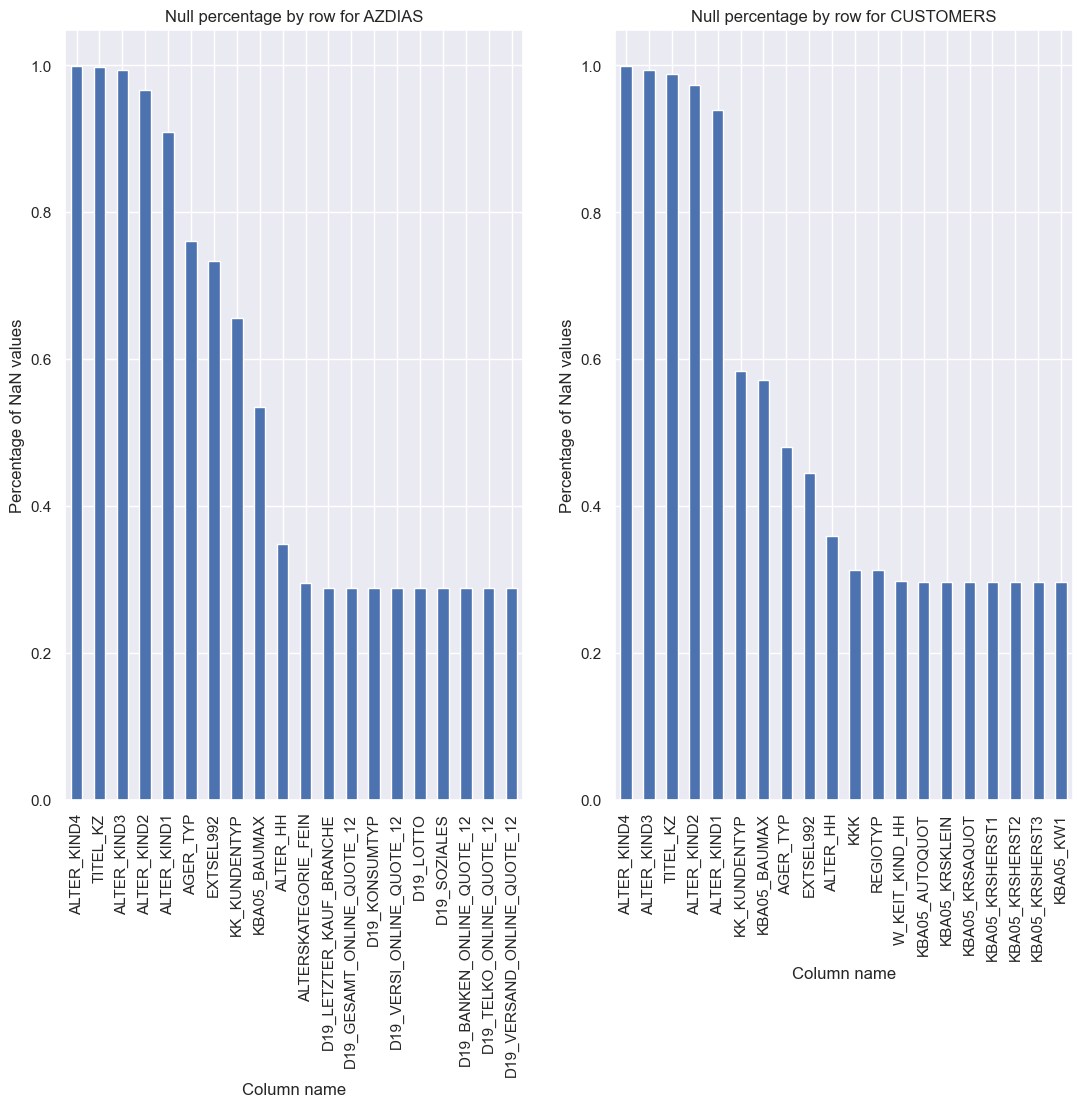

In [242]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 10))

azdias.isnull().mean().sort_values(ascending=False)[:20].plot.bar(ax=axes[0])
axes[0].set_xlabel('Column name')
axes[0].set_ylabel('Percentage of NaN values')
axes[0].set_title("Null percentage by row for AZDIAS")

customers.isnull().mean().sort_values(ascending=False)[:20].plot.bar(ax=axes[1])
axes[1].set_xlabel('Column name')
axes[1].set_ylabel('Percentage of NaN values')
axes[1].set_title("Null percentage by row for CUSTOMERS")

After replacing unknown values with NaN, there are 9 column with null values higher than the rest. I need to drop these 9 columns as it won't contribute much to my clustering algorithm.

In [243]:
to_drop = ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 
           'ALTER_KIND1', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
azdias.drop(columns=to_drop, inplace=True)
customers.drop(columns=to_drop, inplace=True)

##### NaN by rows
I belive there are still many rows, the null percentage of which is high and they should be removed from the dataset in order not to cause any incorrect knowledge when train the clustering algorithm.

Let's look at some visualizations for those case:

In [244]:
def visualize_null_by_row(df, df_name):
    """
    First chart: Calculate the percentage of null for each row and visualize the computed list by histogram.
    Second chart: The cummulative sum of data ratio when increasing the percentage of null.
    """
    fig, axs = plt.subplots(figsize=(14, 12), nrows=1, ncols=2)

    null_by_row = df.isnull().mean(axis=1).sort_values(ascending=False)
    axs[0].hist(null_by_row)
    axs[0].set_xlabel("Percentage of NaN values by row of azdias")
    axs[0].set_ylabel("Count")
    axs[0].set_title("Histogram of null percentage by row")

    (null_by_row.value_counts(normalize=True)*100).sort_index().cumsum().plot.line(ax=axs[1])
    axs[1].set_xlabel("Percentage of null")
    axs[1].set_ylabel("Cummulative of percentage of data (%)")
    axs[1].set_title("Cummulative sum of percentage of rows (normalized) over null percentage")

    fig.suptitle('Visulization for null rows of ' + df_name, fontsize=16)
    plt.show()

**For `azdias`**

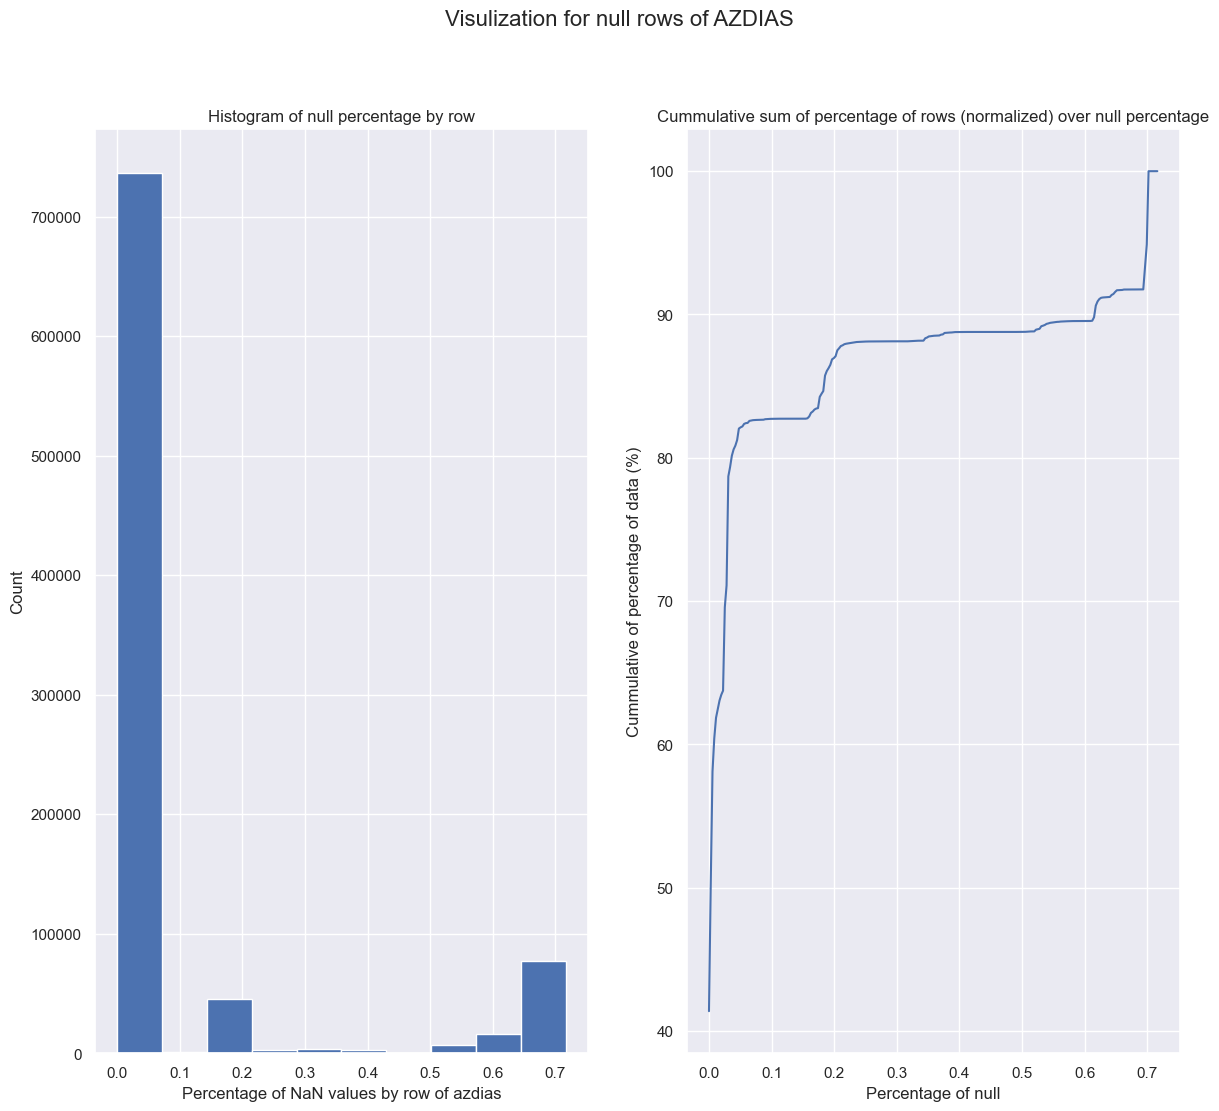

In [245]:
visualize_null_by_row(azdias, 'AZDIAS')

According to the histogram, the null percentage of a row mostly fall into range from 0 to 0.1.

Based on the cummulative chart on the right, rows with null percentage from 0 to 20% accounts for almost 88%. For only rows with null percentage from 0 to 10% already account for 83%.

Let's see the pattern in `customers` before making a decision.

**For `customers`**

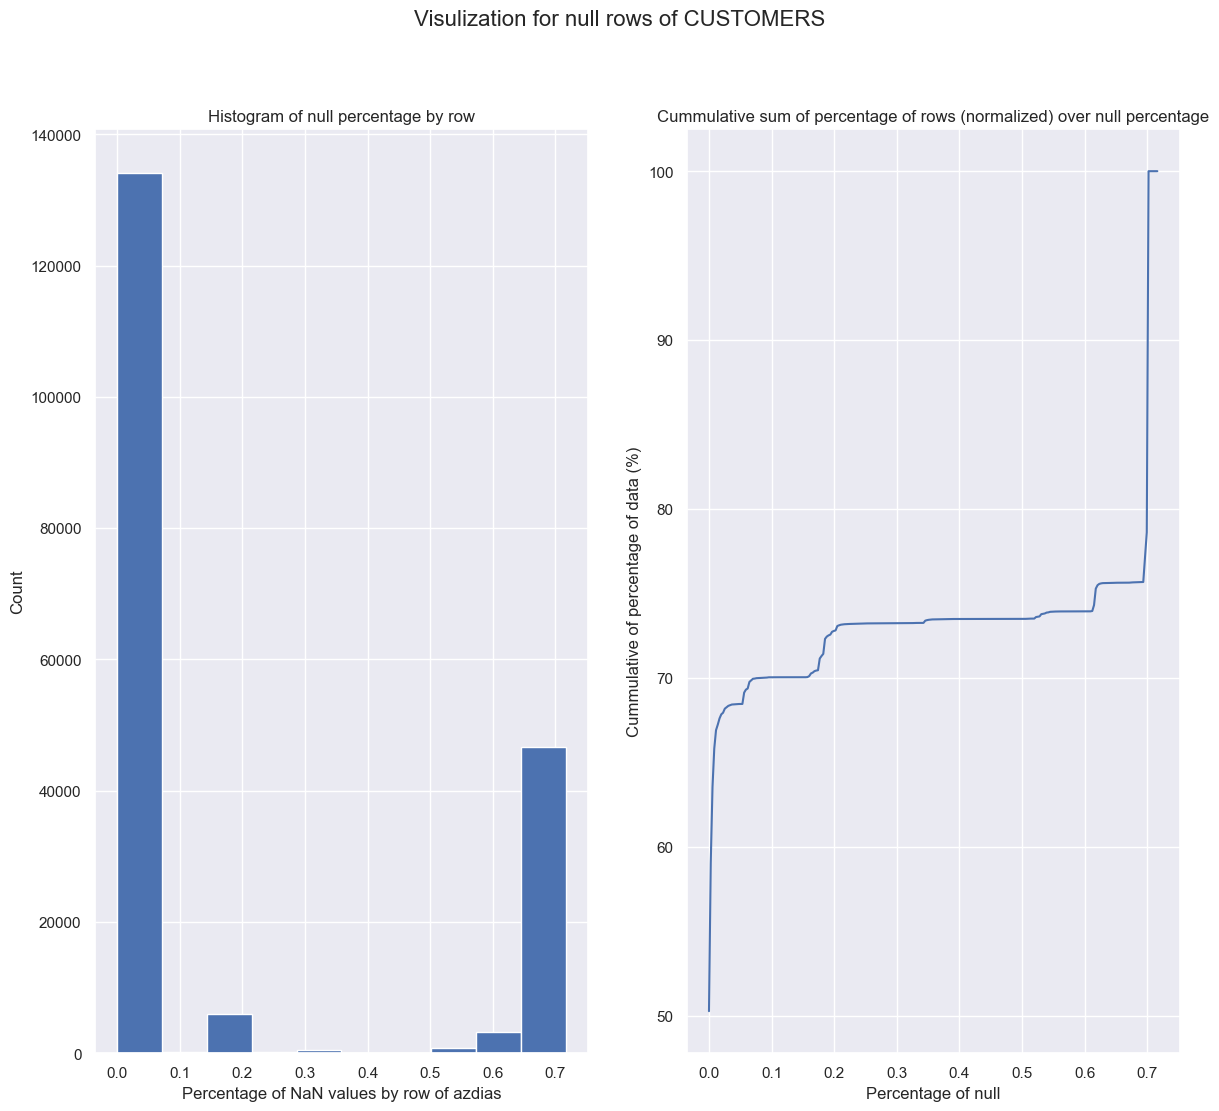

In [246]:
visualize_null_by_row(customers, "CUSTOMERS")

We can see a similar pattern in both dataframes, though `customers` have a lot more rows on 70% NaN data. According to what we found in `azdias` visualization, the highest percentage of null for rows seem to be 5% when keeping about 80% of data. And also maximum 5% null for rows in `customers` happen when keeping about 70%.

Let's check with exact numbers.

In [247]:
# Check with `customers`
null_by_row = customers.isnull().mean(axis=1).sort_values(ascending=False)
cumsum_customers = (null_by_row.value_counts(normalize=True)*100).sort_index().cumsum()

In [248]:
# Suppose that we have maximum null range from 68 to 70 percents
cumsum_customers[(cumsum_customers > 68) & (cumsum_customers < 70)]

0.025281    68.187131
0.028090    68.272181
0.030899    68.354100
0.033708    68.396886
0.036517    68.432889
0.039326    68.441237
0.042135    68.451673
0.044944    68.457412
0.047753    68.463674
0.050562    68.466804
0.053371    68.467326
0.056180    69.136769
0.058989    69.314695
0.061798    69.379396
0.064607    69.769687
0.067416    69.862563
0.070225    69.957005
0.073034    69.969528
0.075843    69.993008
0.078652    69.998226
dtype: float64

From above stats, maximum 5% null percent for rows will need to keep 68% of `customers`.

Let's see with `azdias`.

In [249]:
null_by_row = azdias.isnull().mean(axis=1).sort_values(ascending=False)
cumsum_azdias = (null_by_row.value_counts(normalize=True)*100).sort_index().cumsum()

In [250]:
cumsum_azdias[(cumsum_azdias.index.values > 0.04) & (cumsum_azdias.index.values < 0.06) ]

0.042135    80.848634
0.044944    81.235182
0.047753    82.040482
0.050562    82.127104
0.053371    82.188817
0.056180    82.369132
0.058989    82.419400
dtype: float64

From above stats, maximum 5% null percent for rows will need to keep 82% of `azdias`.

According to the above findings, removing rows with more than **5% NaN** for `azdias` and `customers` is reasonable for following reasons:
1. Keeping about 82% for `azdias` and 68% for `customers` is fairly enough to cover all variances from the whole data.
2. As we will fill NaN values for later use in clustering algorithm, imputing may cause incorrect training and lead to false clustering afterward. Besides, most of columns are categorical, massively filling NaN is not recommended.

In [251]:
null_by_row = azdias.isnull().mean(axis=1)
azdias.drop(list(null_by_row[null_by_row > 0.05].index.values),inplace=True)

null_by_row = customers.isnull().mean(axis=1)
customers.drop(list(null_by_row[null_by_row > 0.05].index.values),inplace=True)

In [252]:
print_shape()

AZDIAS' shape:  (731162, 356)
Customers' shape:  (131212, 356)


#### Data pre-processing
In this steps, I will try to perform:
1. Standardlize the schema of two both datasets by converting object dtype to numerical for bringing into clustering models.
2. Fill NaN values 
3. Find correlated columns to drop

##### Standardlize the data type

In [253]:
azdias.dtypes.value_counts()

float64    264
int64       86
object       6
dtype: int64

In [254]:
customers.dtypes.value_counts()

float64    264
int64       86
object       6
dtype: int64

Each row represents for one data point and to make it possible for clustering algorithms, I need to 
1. keep numeric columns  
2. convert categorical columns into numeric ones.

In [255]:
azdias.select_dtypes("object").head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8.0,54.0,D19_ENERGIE,1992-02-12 00:00:00,W


In [256]:
obj_cols = list(azdias.select_dtypes("object").columns)
obj_cols

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

Let's visualize data for each column
<a id="object_cols"></a>

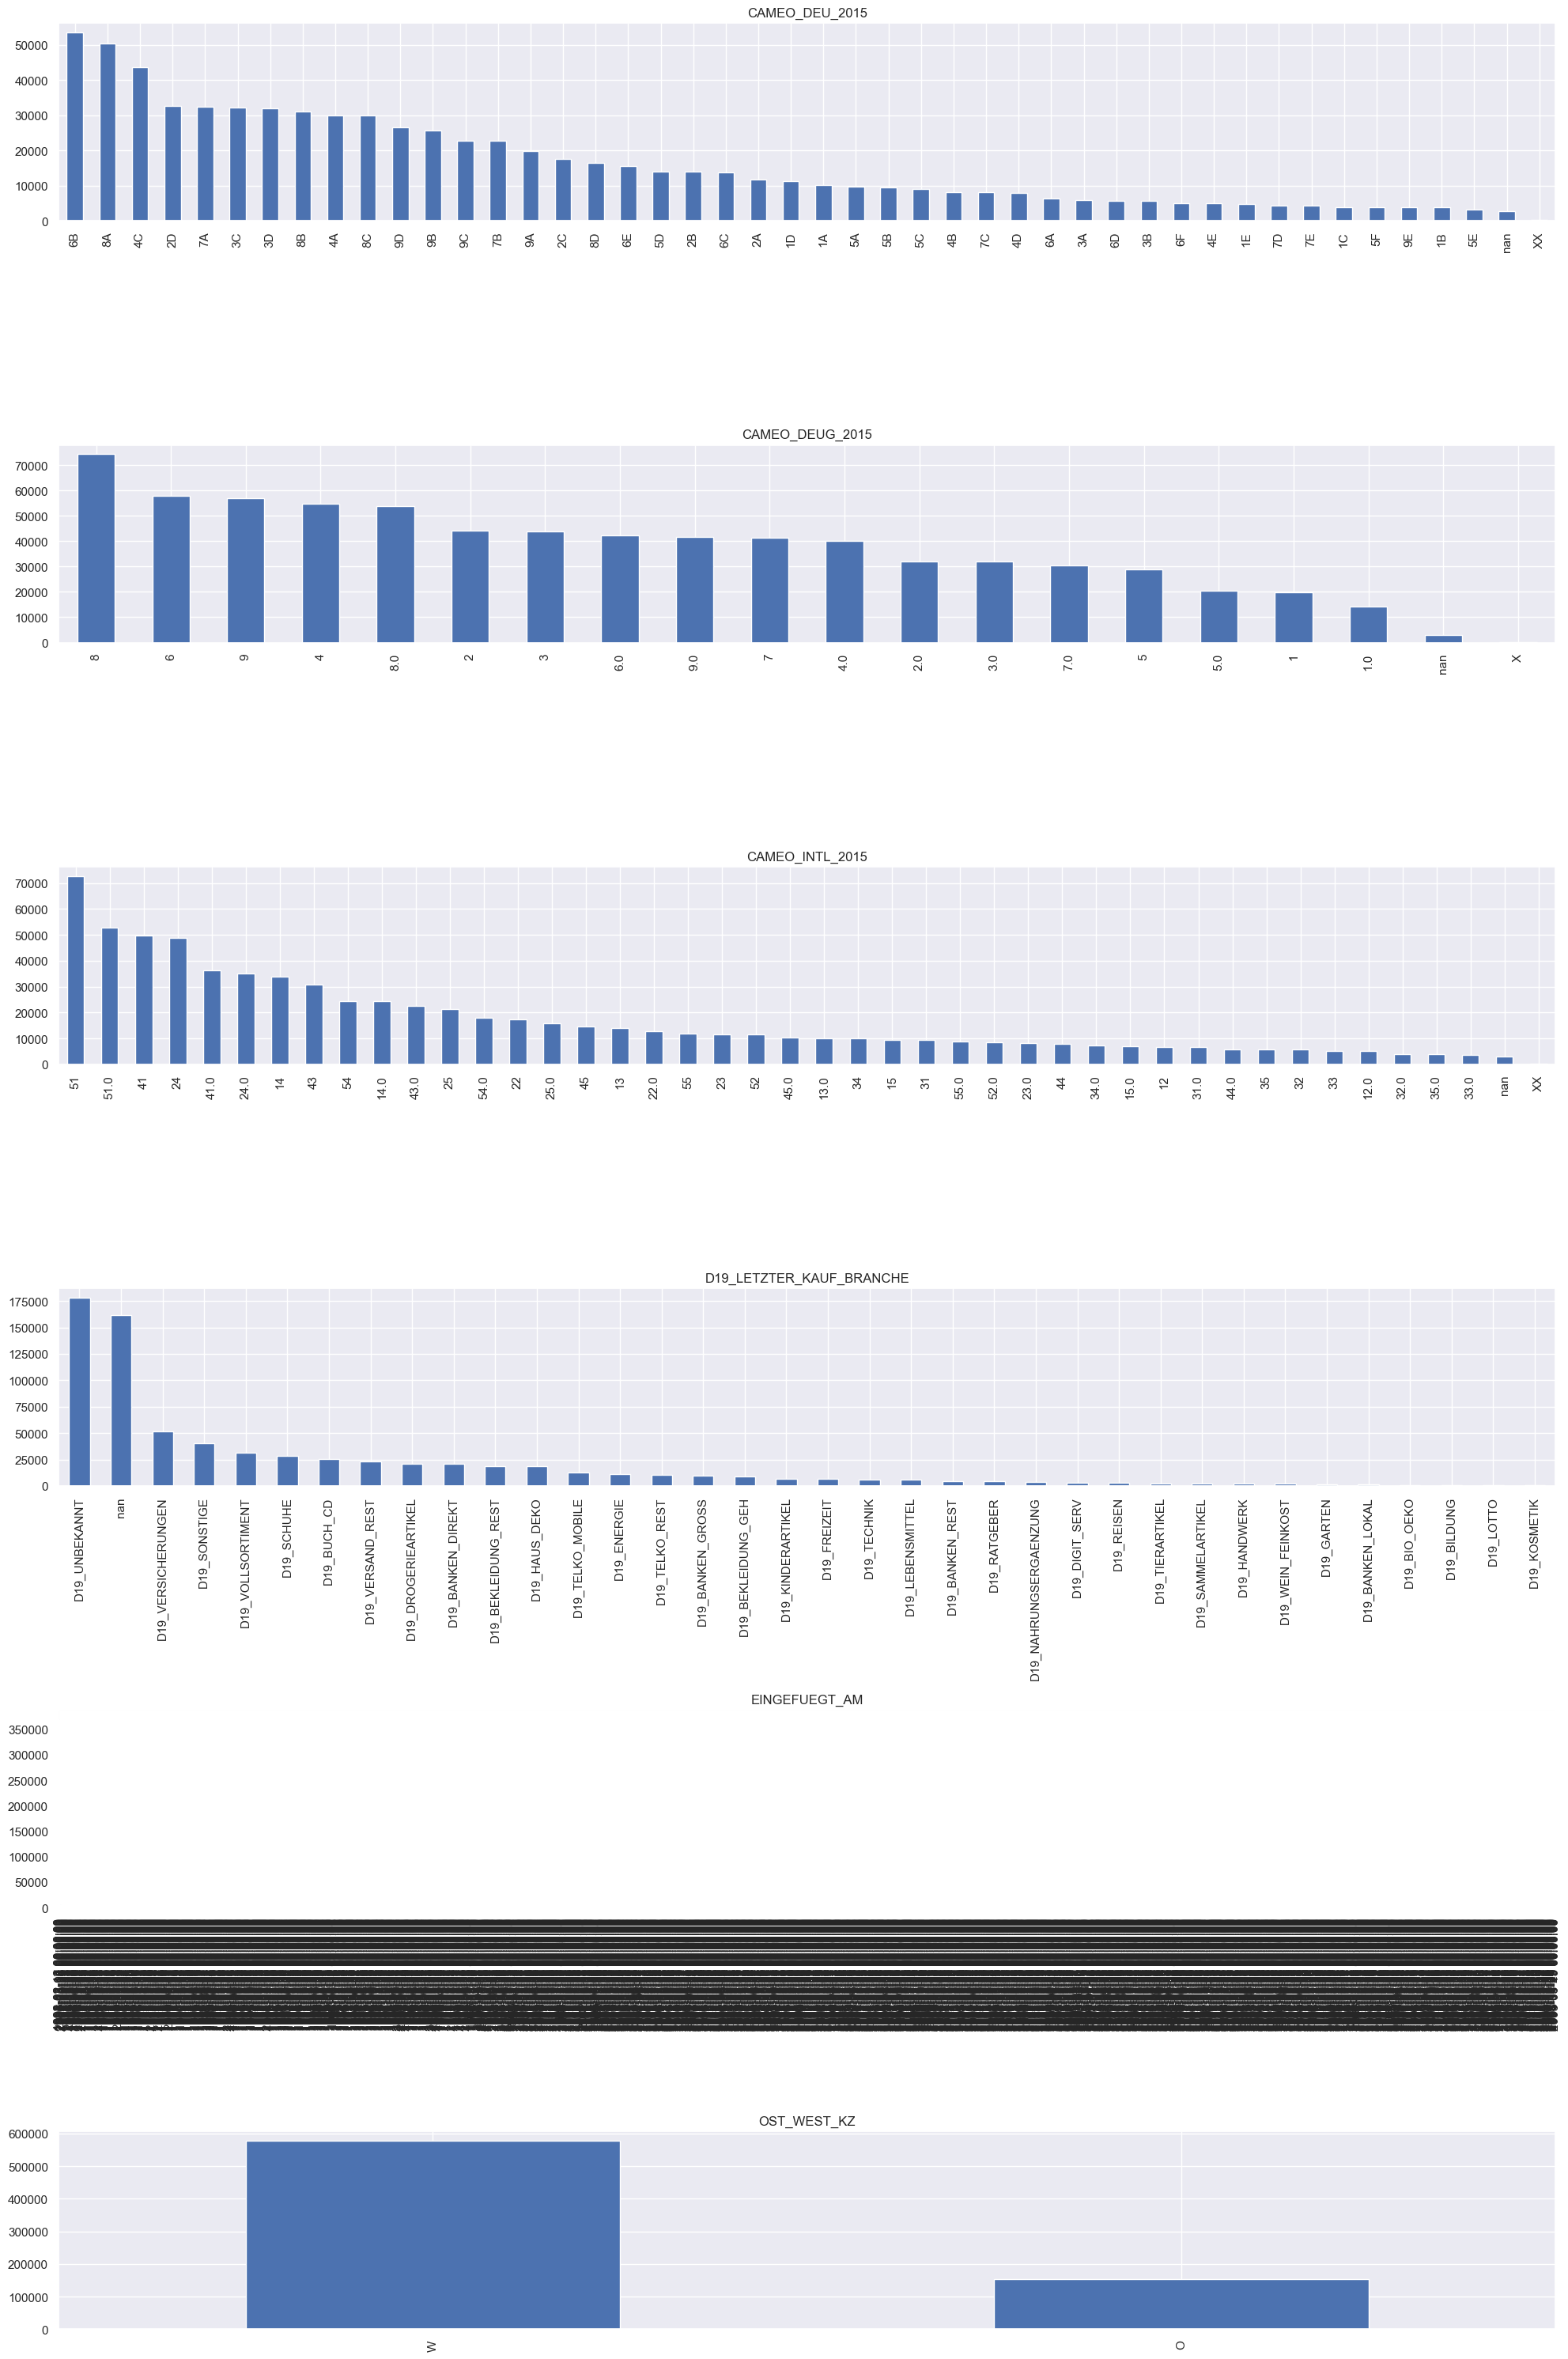

In [257]:
fig, axes = plt.subplots(figsize=(20, 30), nrows=len(obj_cols), ncols=1, tight_layout=True)
for i, col in enumerate(obj_cols):
    azdias[col].value_counts(dropna=False).plot.bar(ax=axes[i], title=col)

**Findings and actions on *object* columns** 

From the chart above, we can see that **CAMEO_DEUG_2015** and **CAMEO_INTL_2015** contains invalid values: 'X' and 'XX'. These need to be replaced by NaN values and then converted to *float* type as their data is numerical. 

For **OST_WEST_KZ**: Only contains 'W' and 'O' => Convert to numeric values based this dict: {'W': 0, 'O': 1}.

In [258]:
azdias.loc[:, 'CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
azdias.loc[:, 'CAMEO_DEUG_2015'] = azdias.loc[:, 'CAMEO_DEUG_2015'].astype(float, copy=False)
azdias.loc[:, 'CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)
azdias.loc[:, 'CAMEO_INTL_2015'] = azdias.loc[:, 'CAMEO_INTL_2015'].astype(float, copy=False)
azdias.loc[:, 'OST_WEST_KZ'] = azdias.loc[:, 'OST_WEST_KZ'].map({'W': 0, 'O': 1})

customers.loc[:, 'CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
customers.loc[:, 'CAMEO_DEUG_2015'] = customers.loc[:, 'CAMEO_DEUG_2015'].astype(float, copy=False)
customers.loc[:, 'CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)
customers.loc[:, 'CAMEO_INTL_2015'] = customers.loc[:, 'CAMEO_INTL_2015'].astype(float, copy=False)
customers.loc[:, 'OST_WEST_KZ'] = customers.loc[:, 'OST_WEST_KZ'].map({'W': 0, 'O': 1})

In [259]:
set(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']).difference(all_info['Attribute'])

{'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'}

Based on [this chart](#object_cols), **CAMEO_DEU_2015** have invalid values 'XX'. Other values is categorical type, so I will convert 'XX' to NaN and then use one hot encoding with numpy. For **D19_LETZTER_KAUF_BRANCHE**, as it's also categorical type, one hot encoding will be also used on this column. I will do these transformations for this columns as the last step.

For remaining columns, I could not find , **EINGEFUEGT_AM** in the description dataframe. Let's take a look.

In [261]:
azdias['EINGEFUEGT_AM'].head()

1    1992-02-10 00:00:00
2    1992-02-12 00:00:00
3    1997-04-21 00:00:00
4    1992-02-12 00:00:00
5    1992-02-12 00:00:00
Name: EINGEFUEGT_AM, dtype: object

In [262]:
azdias['EINGEFUEGT_AM'].tail()

891216    1992-02-10 00:00:00
891217    1992-02-10 00:00:00
891218    1992-02-10 00:00:00
891219    1992-02-12 00:00:00
891220    1992-02-10 00:00:00
Name: EINGEFUEGT_AM, dtype: object

In [263]:
# I will convert to datetime for more information:
time_col = pd.to_datetime(azdias['EINGEFUEGT_AM'])
time_col.describe()

C:\Users\NHAN\AppData\Local\Temp\ipykernel_23948\2976884727.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  time_col.describe()


count                  731162
unique                   2813
top       1992-02-10 00:00:00
freq                   369238
first     1991-06-17 00:00:00
last      2005-05-11 00:00:00
Name: EINGEFUEGT_AM, dtype: object

<AxesSubplot:>

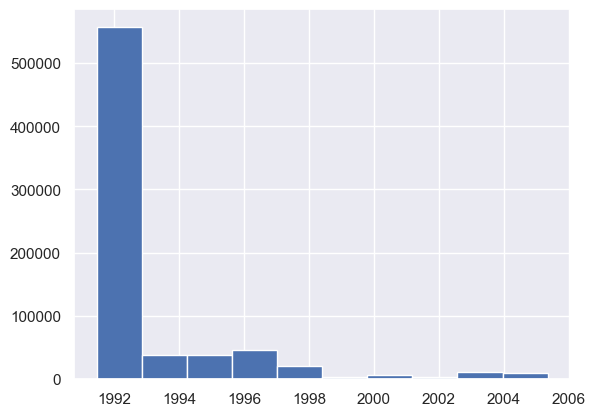

In [264]:
time_col.hist()

We can see the unique value is high. If brought into clustering model, this column will confuse the model by having too many value spread all across the axis. It must be easier for the model if I keep only *year* information from these datetime.

In [265]:
time_col = pd.DatetimeIndex(azdias['EINGEFUEGT_AM']).year

In [266]:
pd.Series(time_col).value_counts()

1992    557961
1995     40775
1996     28478
1994     27728
1993     23147
1997     18956
2003      9831
2004      6031
2000      5623
2005      3731
1998      3292
2002      3046
2001      1541
1999      1019
1991         3
Name: EINGEFUEGT_AM, dtype: int64

In [267]:
azdias.loc[:, 'year'] = pd.DatetimeIndex(azdias['EINGEFUEGT_AM']).year
customers.loc[:, 'year'] = pd.DatetimeIndex(customers['EINGEFUEGT_AM']).year

In [268]:
azdias.drop(columns='EINGEFUEGT_AM', inplace=True)
customers.drop(columns='EINGEFUEGT_AM', inplace=True)

In [269]:
azdias.dtypes.value_counts()

float64    266
int64       88
object       2
dtype: int64

In [270]:
customers.dtypes.value_counts()

float64    266
int64       88
object       2
dtype: int64

Perform one-hot encoding for **D19_LETZTER_KAUF_BRANCHE** and **CAMEO_DEU_2015**

In [271]:
azdias = pd.get_dummies(azdias, columns=['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015'])
customers = pd.get_dummies(customers, columns=['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015'])

In [272]:
azdias.dtypes.value_counts()

float64    266
int64       88
uint8       80
dtype: int64

In [273]:
customers.dtypes.value_counts()

float64    266
int64       88
uint8       80
dtype: int64

Now our data only hold numeric values

#### Filling NaN values
Now, there are only few NaN values left in the data. Since most of columns is categorical, we fill these NaN with **mode**.

In [274]:
imputer = SimpleImputer(strategy="most_frequent")

In [275]:
azdias_cols = list(azdias.columns)
azdias_imp = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias_imp, columns=azdias_cols)

customers_cols = list(customers.columns)
customers_imp = imputer.fit_transform(customers)
customers = pd.DataFrame(customers_imp, columns=azdias_cols)

c:\Users\NHAN\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
c:\Users\NHAN\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = 

Check if there is any NaN cell

In [276]:
print(azdias.isnull().any().sum())
print(customers.isnull().any().sum())

0
0


#### Find highly correlated columns to remove
`customers` is not a subset of `azdias` so two columns is correlated in `azdias` may not be correlated in `customers`. That's why I will find the most correlated columns in each dataframe. Then drop columns in both dataframe which is the intersection of mentioned correlated columns.

Correlated columns is ones whose Pearson values is over 0.95.

In [277]:
corr_matrix = azdias.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), 1).astype(np.bool)
)

azdias_to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
azdias_to_drop

C:\Users\NHAN\AppData\Local\Temp\ipykernel_23948\1180515216.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(corr_matrix.shape), 1).astype(np.bool)


['ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'D19_VERSAND_ONLINE_DATUM',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB',
 'PLZ8_GBZ',
 'PLZ8_HHZ']

In [278]:
corr_matrix = customers.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), 1).astype(np.bool)
)

customers_to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
customers_to_drop

C:\Users\NHAN\AppData\Local\Temp\ipykernel_23948\2894682320.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(corr_matrix.shape), 1).astype(np.bool)


['ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB',
 'PLZ8_GBZ',
 'PLZ8_HHZ']

In [279]:
to_drop = list(
    set(azdias_to_drop).intersection(customers_to_drop)
)
to_drop

['ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'KBA13_KMH_250',
 'LP_FAMILIE_GROB',
 'KBA13_HERST_SONST',
 'PLZ8_GBZ',
 'LP_STATUS_GROB',
 'LP_LEBENSPHASE_GROB',
 'PLZ8_HHZ']

In [280]:
azdias.drop(columns=to_drop, inplace=True)
customers.drop(columns=to_drop, inplace=True)

In [281]:
azdias.dtypes.value_counts()

float64    425
dtype: int64

In [282]:
customers.dtypes.value_counts()

float64    425
dtype: int64

In [283]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731162 entries, 0 to 731161
Columns: 425 entries, AKT_DAT_KL to CAMEO_DEU_2015_XX
dtypes: float64(425)
memory usage: 2.3 GB


In [284]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131212 entries, 0 to 131211
Columns: 425 entries, AKT_DAT_KL to CAMEO_DEU_2015_XX
dtypes: float64(425)
memory usage: 425.5 MB


In [97]:
print(azdias.isnull().any(axis=1).sum())
print(customers.isnull().any(axis=1).sum())

0
0


In [285]:
# write data to disk
azdias.to_csv("cleaned_azdias.csv", index=False)
customers.to_csv("cleaned_customers.csv", index=False)

## Part 2: Customer Segmentation Report

Assume that there will be a cluster model used to cluster both `azdias` and `customers` which I cleaned. Then, the distribution of `customers` in each group may be different from the `azdias`'s. The reason is that the mail-order sales company is more interested in some specific groups of people and they want to know the characteristics of groups to capture more customers in the future.

To achieve that, in this part, I will do the following steps:
1. Reduce the number of dimensions using Pricipal Component Analysis (PCA). As `customers` and `azdias` has so many columns and most of the columns are categorical, the amount of useful information in these datasets are scattered. PCA will help to focus the amount of useful information on the first principal components while the last pricipal components will contain very little information and we can remove these components without causing too much information loss in datasets. Besides, PCA also let us know for a specific principal component, which features contributes the most.

2. Cluster `azdias` and `customers` using KMeans. Fitting KMeans model with the demographics population `azdias` and then performing clustering on `customers` dataset. This step will help to classify people into different groups 

3. From `azdias`, determine customers that is interested and not interested by the company. In this step, we compare the difference in the ratio of the same clustered group on both `azdias` and `customers` and then filter out customers belonging to groups with a significant percentage difference between `customers` and `azdias`. 

4. For each group, analyze the pattern on columns which contribute most to the first components. I only focus on the first principal component because only for this component there already over 400 features to analyze! For the scope of this analysis, I work on first ten features with highest contribution to the first principal component. 

5. Based on the analysis, I draw conclusion about targeted customers of mail-order sales company.

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In this part, I use KMeans clustering models to determine groups in `azdias` and `customers`.

In [3]:
# read cleaned data
azdias = pd.read_csv("cleaned_azdias.csv")
customers = pd.read_csv("cleaned_customers.csv")

In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731162 entries, 0 to 731161
Columns: 425 entries, AKT_DAT_KL to CAMEO_DEU_2015_XX
dtypes: float64(425)
memory usage: 2.3 GB


In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131212 entries, 0 to 131211
Columns: 425 entries, AKT_DAT_KL to CAMEO_DEU_2015_XX
dtypes: float64(425)
memory usage: 425.5 MB


### Step 0: Preprocess data and reduce dimensions before bringing into clustering models
This step is to ensure the data used by the clustering algorithm is in the right, optimized shape. Specificially, I would do
1. scaling data to put each column in the same scale
2. reduce the number of dimensions using PCA to drop any redundant information in the data and accumalate all variances which scatters over the whole dataset to first principal components. Besides, based on the linear transform formed by PCA, I can also determine which features/attributes have most impact on the principal components I'm interested in.

#### Scale the data
Though all columns are categorical variables and their values are recorded in different scale, we also need to put them in same scale level for obtaining accurate performance result when training with clustering model.

Load or create scalers

In [4]:
# when refit=True, new sc will be created and 
# fit with the current dataset regardless that there exists models in disk
refit = False 
az_scaler_fname = "scaler_azdias.pkl"
cus_scaler_fname = "scaler_customers.pkl"

check = refit or not(os.path.exists(az_scaler_fname) and os.path.exists(cus_scaler_fname)) 

if check:
    print("Create new scalers")
    azdias_scaler = StandardScaler().fit(azdias)
    customers_scaler = StandardScaler().fit(customers)
    
    # dump scaler
    with open(az_scaler_fname, 'wb') as f:
        pickle.dump(azdias_scaler, f)

    with open(cus_scaler_fname, 'wb') as f:
        pickle.dump(customers_scaler, f)
else:
    # load scalers
    print("Load scalers")
    with open(az_scaler_fname, 'rb') as f:
        azdias_scaler = pickle.load(f)
    
    with open(cus_scaler_fname, 'rb') as f:
        customers_scaler = pickle.load(f)

Load scalers


Transform with scalers

In [5]:
azdias_scaled = azdias_scaler.transform(azdias)
customers_scaled = customers_scaler.transform(customers)

azdias_cols = list(azdias.columns)
customers_cols = list(customers.columns)

azdias = pd.DataFrame(azdias_scaled, columns=azdias_cols)
customers = pd.DataFrame(customers_scaled, columns=customers_cols)

In [13]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE

In [14]:
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE

#### Principal component analysis (PCA)

In [292]:
pca = PCA().fit(azdias)

Text(0.5, 1.0, 'PCA')

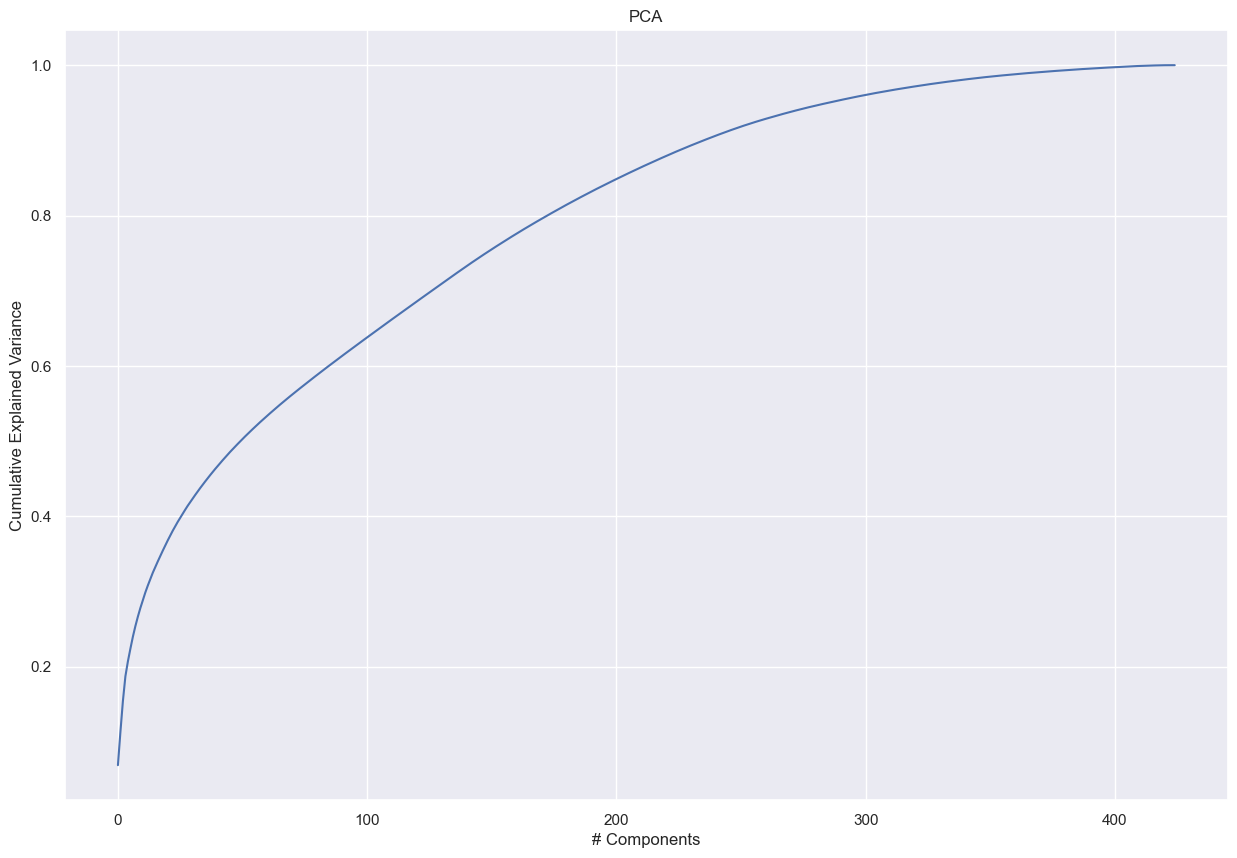

In [293]:
plt.figure(figsize=(15,10))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('# Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA')

In [294]:
np.sum(pca.explained_variance_ratio_[:170])

0.7938048347022332

We can see from the chart, keeping about 170 components will keep about 80% information residing in the `azdias` data. With that in mind, I will create another PCA object and hold only 170 components to lessen the burden on clustering algorthm later.

Then I apply this PCA transformation on both `azdias` and `customers`.

Load or create pca_reduce

In [296]:
# when refit=True, new scaler will be created and 
# fit with the current dataset regardless that there exists models in disk
refit = False
pca_reduce_fname = "models/pca_reduce.pkl"
n_components = 170

check = refit or not(os.path.exists(pca_reduce_fname))

if check: 
    print("Create new PCA Reduce")
    pca_reduce = PCA(n_components=n_components).fit(azdias)
    
    # dump pca_reduce
    with open(pca_reduce_fname, 'wb') as f:
        pickle.dump(pca_reduce, f)
else:
    # load pca_reduce
    print("Load PCA Reduce")
    with open(pca_reduce_fname, 'rb') as f:
        pca_reduce = pickle.load(f)

Create new PCA Reduce


Transform with pca_reduce

In [297]:
# Apply PCA with 170 component for `azdias` and `customers`
reduced_azdias = pd.DataFrame(pca_reduce.transform(azdias))
reduced_customers = pd.DataFrame(pca_reduce.transform(customers))

#### Interpretation of PCA components
We may want to know that for component with highest variance, which attributes contribute the most and how much for these contribution?

In [298]:
# Get weights of PCA transformation
weights = pd.DataFrame(pca_reduce.components_, columns=azdias_cols)

def display_contribution_of_columns_to_a_component(pca, comp_order, weights, display_atts=5):
    print("Componet {0} accounts for % information: {1} %".format(comp_order, pca.explained_variance_ratio_[comp_order] * 100))
    print("\nAttributes and their contributions: ")
    
    stats = weights.loc[comp_order].sort_values(ascending=False)
    print("* Highest positive contributions: ")
    print(stats[:display_atts])
    
    print("\n* Highest negative contributions: ")
    print(stats[-display_atts:])
    
#     return list(stats[:display_atts].index.values) + list(stats[-display_atts:].index.values)

In [300]:
display_contribution_of_columns_to_a_component(pca_reduce, 0, weights)

Componet 0 accounts for % information: 6.898654057343552 %

Attributes and their contributions: 
* Highest positive contributions: 
MOBI_REGIO        0.136428
PLZ8_ANTG1        0.129523
KBA13_ANTG1       0.128947
KBA05_ANTG1       0.126154
LP_STATUS_FEIN    0.126097
Name: 0, dtype: float64

* Highest negative contributions: 
HH_EINKOMMEN_SCORE   -0.122865
KBA13_BAUMAX         -0.122878
KBA13_ANTG4          -0.123589
KBA13_ANTG3          -0.128300
PLZ8_ANTG3           -0.128850
Name: 0, dtype: float64


In [301]:
display_contribution_of_columns_to_a_component(pca_reduce, 1, weights)

Componet 1 accounts for % information: 4.412626719289378 %

Attributes and their contributions: 
* Highest positive contributions: 
ONLINE_AFFINITAET        0.153980
PRAEGENDE_JUGENDJAHRE    0.144178
CJT_TYP_2                0.143136
D19_GESAMT_ANZ_24        0.141127
CJT_TYP_1                0.140907
Name: 1, dtype: float64

* Highest negative contributions: 
D19_VERSAND_ONLINE_DATUM   -0.132446
CJT_TYP_4                  -0.133431
FINANZ_VORSORGER           -0.133494
CJT_TYP_5                  -0.136996
D19_GESAMT_ONLINE_DATUM    -0.137343
Name: 1, dtype: float64


In [302]:
display_contribution_of_columns_to_a_component(pca_reduce, 2, weights)

Componet 2 accounts for % information: 4.117129765078595 %

Attributes and their contributions: 
* Highest positive contributions: 
KBA13_HERST_BMW_BENZ           0.182475
KBA13_SEG_OBEREMITTELKLASSE    0.157367
KBA13_MERCEDES                 0.155803
KBA13_BMW                      0.152364
KBA13_SITZE_4                  0.147763
Name: 2, dtype: float64

* Highest negative contributions: 
KBA13_HALTER_20        -0.115601
KBA13_HALTER_25        -0.120840
KBA13_KMH_140_210      -0.125341
KBA13_SEG_KLEINWAGEN   -0.130338
KBA13_SITZE_5          -0.151717
Name: 2, dtype: float64


In [303]:
display_contribution_of_columns_to_a_component(pca_reduce, 119, weights)

Componet 119 accounts for % information: 0.2348670175022358 %

Attributes and their contributions: 
* Highest positive contributions: 
CAMEO_DEU_2015_XX    0.294687
CAMEO_DEU_2015_1B    0.247385
CAMEO_DEU_2015_6A    0.226337
CAMEO_DEU_2015_4A    0.185984
CAMEO_DEU_2015_7E    0.184075
Name: 119, dtype: float64

* Highest negative contributions: 
CAMEO_DEU_2015_9A                      -0.189102
CAMEO_DEU_2015_3A                      -0.207907
CAMEO_DEU_2015_5A                      -0.234996
D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG   -0.280617
CAMEO_DEU_2015_4E                      -0.321698
Name: 119, dtype: float64


<a id="pc0"></a>
We can see that going from the first component to the third component, the amount of information each dimension keep is decreasing. And till the last component, it hold only 0.25 percent of information for the whole dataset. That is the reason where we can drop last 150 components in which we can still hold most of variance of the dataset.

In addtion, regarding the component 0, we also found ten features that is positively and negatively related to it. 

They are **MOBI_REGIO**, **PLZ8_ANTG1**, **KBA13_ANTG1**, **KBA05_ANTG1**, **LP_STATUS_FEIN**, **HH_EINKOMMEN_SCORE**, **KBA13_BAUMAX**, **KBA13_ANTG4**, **KBA13_ANTG3**, **PLZ8_ANTG3**. These column will be used for determining characteristics of targeted customers later.


### Step 1: Apply KMeans clustering
In this steps, I will perform the clustering reports for data `azdias` and `customers` with following steps:
1. Find optimal number of KMeans clusters and train KMeans models.
2. Use the trained KMeans to predict group for each person in both `azdias` and ` customers` (Of course, on the reduced version of both dataset)
3. Compare the predicted result of two dataset and find the characteristics of each group for conclusion.

#### Find optimal number of KMeans clusters

In [304]:
# The whole dataset is too large for train KMeans clusters, so I only sample for 40000 records
sample_azdias = reduced_azdias.sample(70000)
k_list = range(2,23)
score_list = [KMeans(n_clusters=k).fit(sample_azdias).score(sample_azdias) for k in k_list]

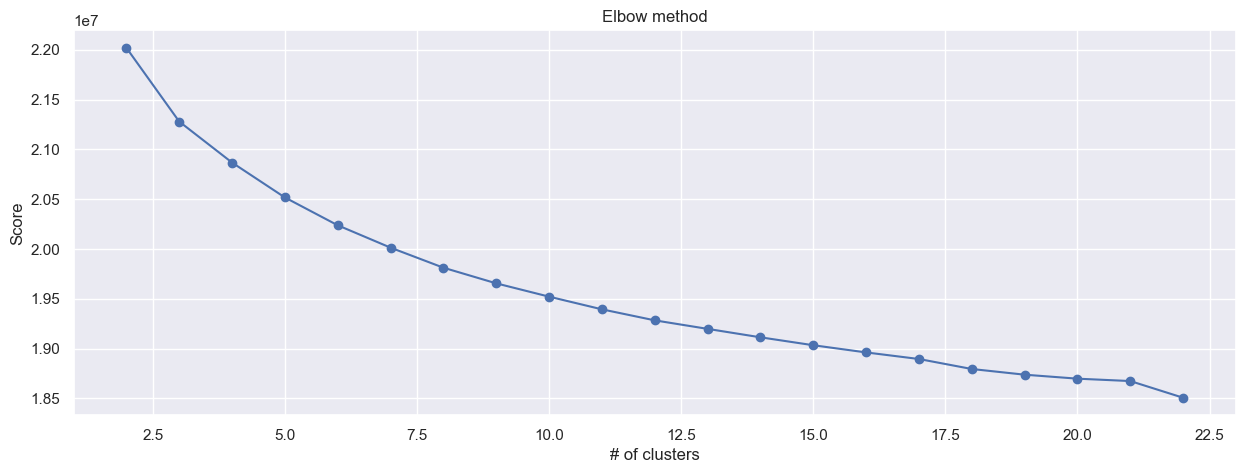

In [305]:
plt.figure(figsize=(15,5))
plt.plot(k_list, abs(np.array(score_list)), linestyle='-', marker='o')
plt.title('Elbow method')
plt.xlabel('# of clusters')
plt.ylabel('Score');

As we can see from the elbow chart, when the number of clusters comes to 18, the score still changes but not much. We can choose this number of components for our clustering models.

#### Train and predict group for each person

Load or create KMeans

In [309]:
# when refit=True, new scaler will be created and 
# fit with the current dataset regardless that there exists models in disk
refit = True
num_clusters = 18
kmeans_fname = "models/kmeans_{0}_clusters.pkl".format(num_clusters)

check = refit or not(os.path.exists(kmeans_fname))

if check: 
    print("Create new KMeans")
    Kfitted = KMeans(n_clusters=num_clusters).fit(reduced_azdias)
    
    # dump KMeans
    with open(kmeans_fname, 'wb') as f:
        pickle.dump(Kfitted, f)
else:
    # load pca_reduce
    print("Load KMeans")
    with open(kmeans_fname, 'rb') as f:
        Kfitted = pickle.load(f)

Create new KMeans


Run KMeans model

In [310]:
azdias_clustered_arr = Kfitted.predict(reduced_azdias)
clustered_azdias = pd.DataFrame(azdias_clustered_arr, columns=['cluster'])

customers_clustered_arr = Kfitted.predict(reduced_customers)
clustered_customers = pd.DataFrame(customers_clustered_arr, columns = ['cluster'])

# Save the predicted result for later use
clustered_azdias.to_pickle("results/clustered_azdias")
clustered_customers.to_pickle("results/clustered_customers")

### Step 3: From `azdias`, determine customers that is interested and not interested by the company.

In this step, we compare the difference in the ratio of the same clustered group on both `azdias` and `customers` and then filter out customers belonging to groups with a significant percentage difference between `customers` and `azdias`. 

In [3]:
# Load predicted results
with open("results/clustered_azdias", 'rb') as f:
    clustered_azdias = pickle.load(f)
    
with open("results/clustered_customers", 'rb') as f:
    clustered_customers = pickle.load(f)

Let's visualize distribution of `azdias` and `customer` by each group on a same bar chart

In [5]:
# calculate statistics of clustered azdias and customers
norm_cus = clustered_customers.cluster.value_counts(normalize=True).sort_index()
norm_az = clustered_azdias.cluster.value_counts(normalize=True).sort_index()

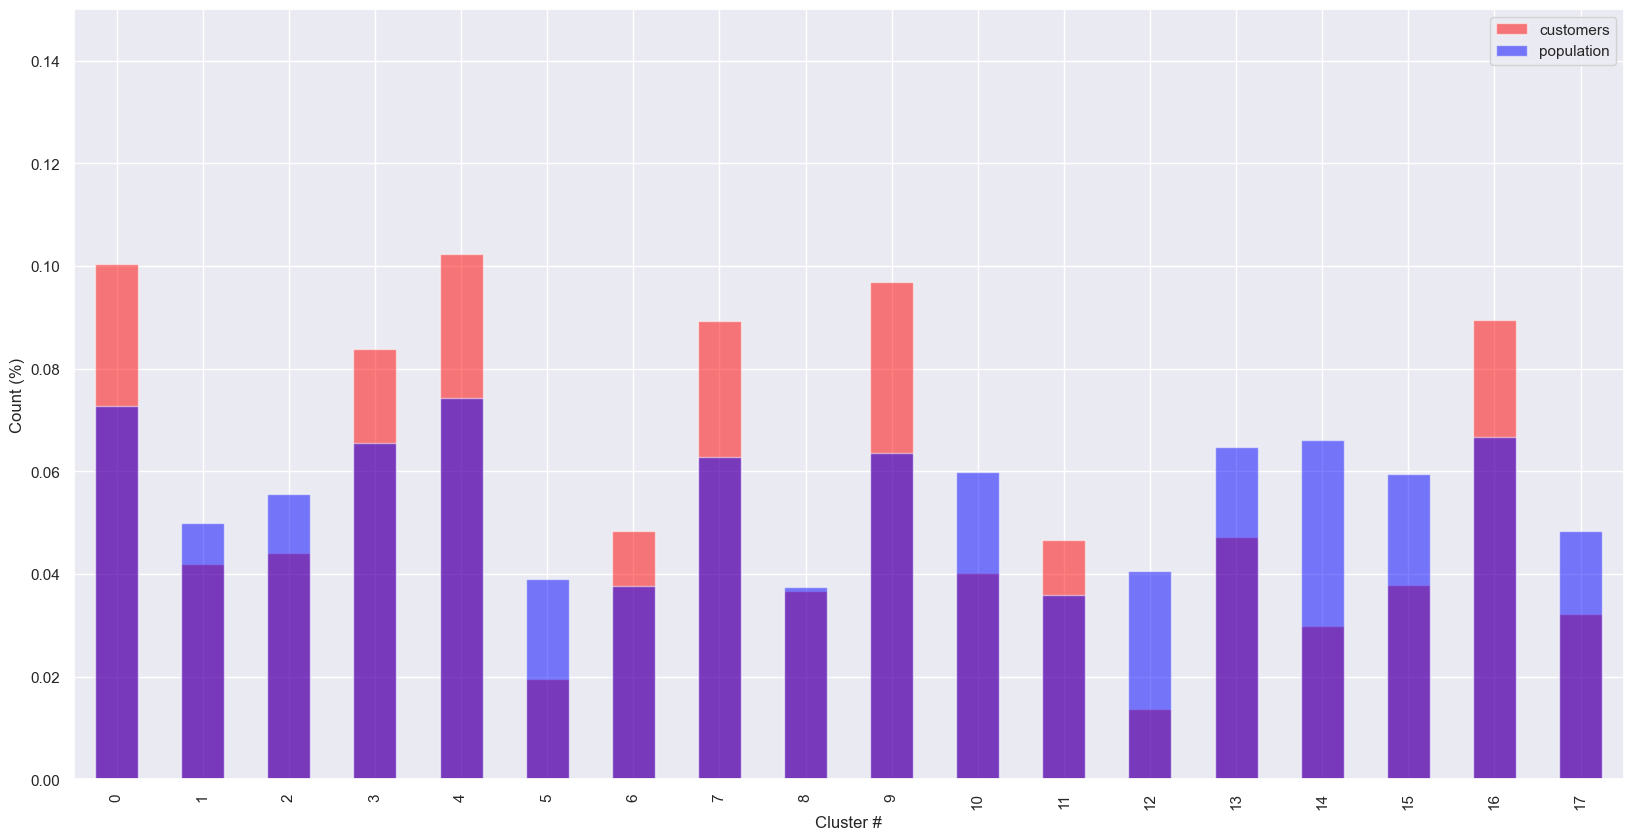

In [6]:
plt.figure(figsize=(20,10))
norm_cus.plot.bar(alpha=0.5, color='red', label='customers')
norm_az.plot.bar(alpha=0.5, label='population', color='blue')

plt.ylim([0,0.15])
plt.legend()
plt.xlabel('Cluster #')
plt.ylabel('Count (%)');

From the chart, customers ratios in group 1, 3, 4, 8, 14 are higher than the population's. In constrast, group 2, 10, 11, 15 have higher population ratio than customers'. To have an exact differences in ratio between two datasets, let's subtract in pair and sort descendingly.

In [7]:
(norm_cus - norm_az).sort_values(ascending=False)

9     0.033399
4     0.028044
0     0.027775
7     0.026455
16    0.022753
3     0.018203
6     0.010759
11    0.010629
8    -0.000651
1    -0.008081
2    -0.011471
17   -0.016325
13   -0.017530
5    -0.019542
10   -0.019643
15   -0.021601
12   -0.026863
14   -0.036311
Name: cluster, dtype: float64

Three groups are more interested by the company are group 0, 4, 9 with the difference is over 2.5%. Constrastly, the company is less interested in group 12, 14, 15 as their differences is negative and above 2%.

So I label customers from group 0, 4, 9 as **client** and from group 12, 14, 15 as **not_client** and extract them from `azdias` based on their groups.

As I mentioned [here](#pc0), we should focus only on ten columns which is related most to the first principal component.

In [15]:
columns_pc0 = ['MOBI_REGIO', 'PLZ8_ANTG1', 'KBA13_ANTG1', 'KBA05_ANTG1', 
               'LP_STATUS_FEIN', 'HH_EINKOMMEN_SCORE', 'KBA13_BAUMAX',
               'KBA13_ANTG4', 'KBA13_ANTG3', 'PLZ8_ANTG3']
azdias_sub = azdias.loc[:, columns_pc0]

In [16]:
# Merge predicted group for determining user's group.
azdias_sub['cluster'] = clustered_azdias

In [17]:
over = [0, 4, 9]
under = [12, 14, 15]
client = azdias_sub[azdias_sub['cluster'].isin(over)]
not_client = azdias_sub[azdias_sub['cluster'].isin(under)]

In [18]:
client.shape, not_client.shape

((153823, 11), (121508, 11))

Let's visualize first five column in which they are positively proportional to the first component.

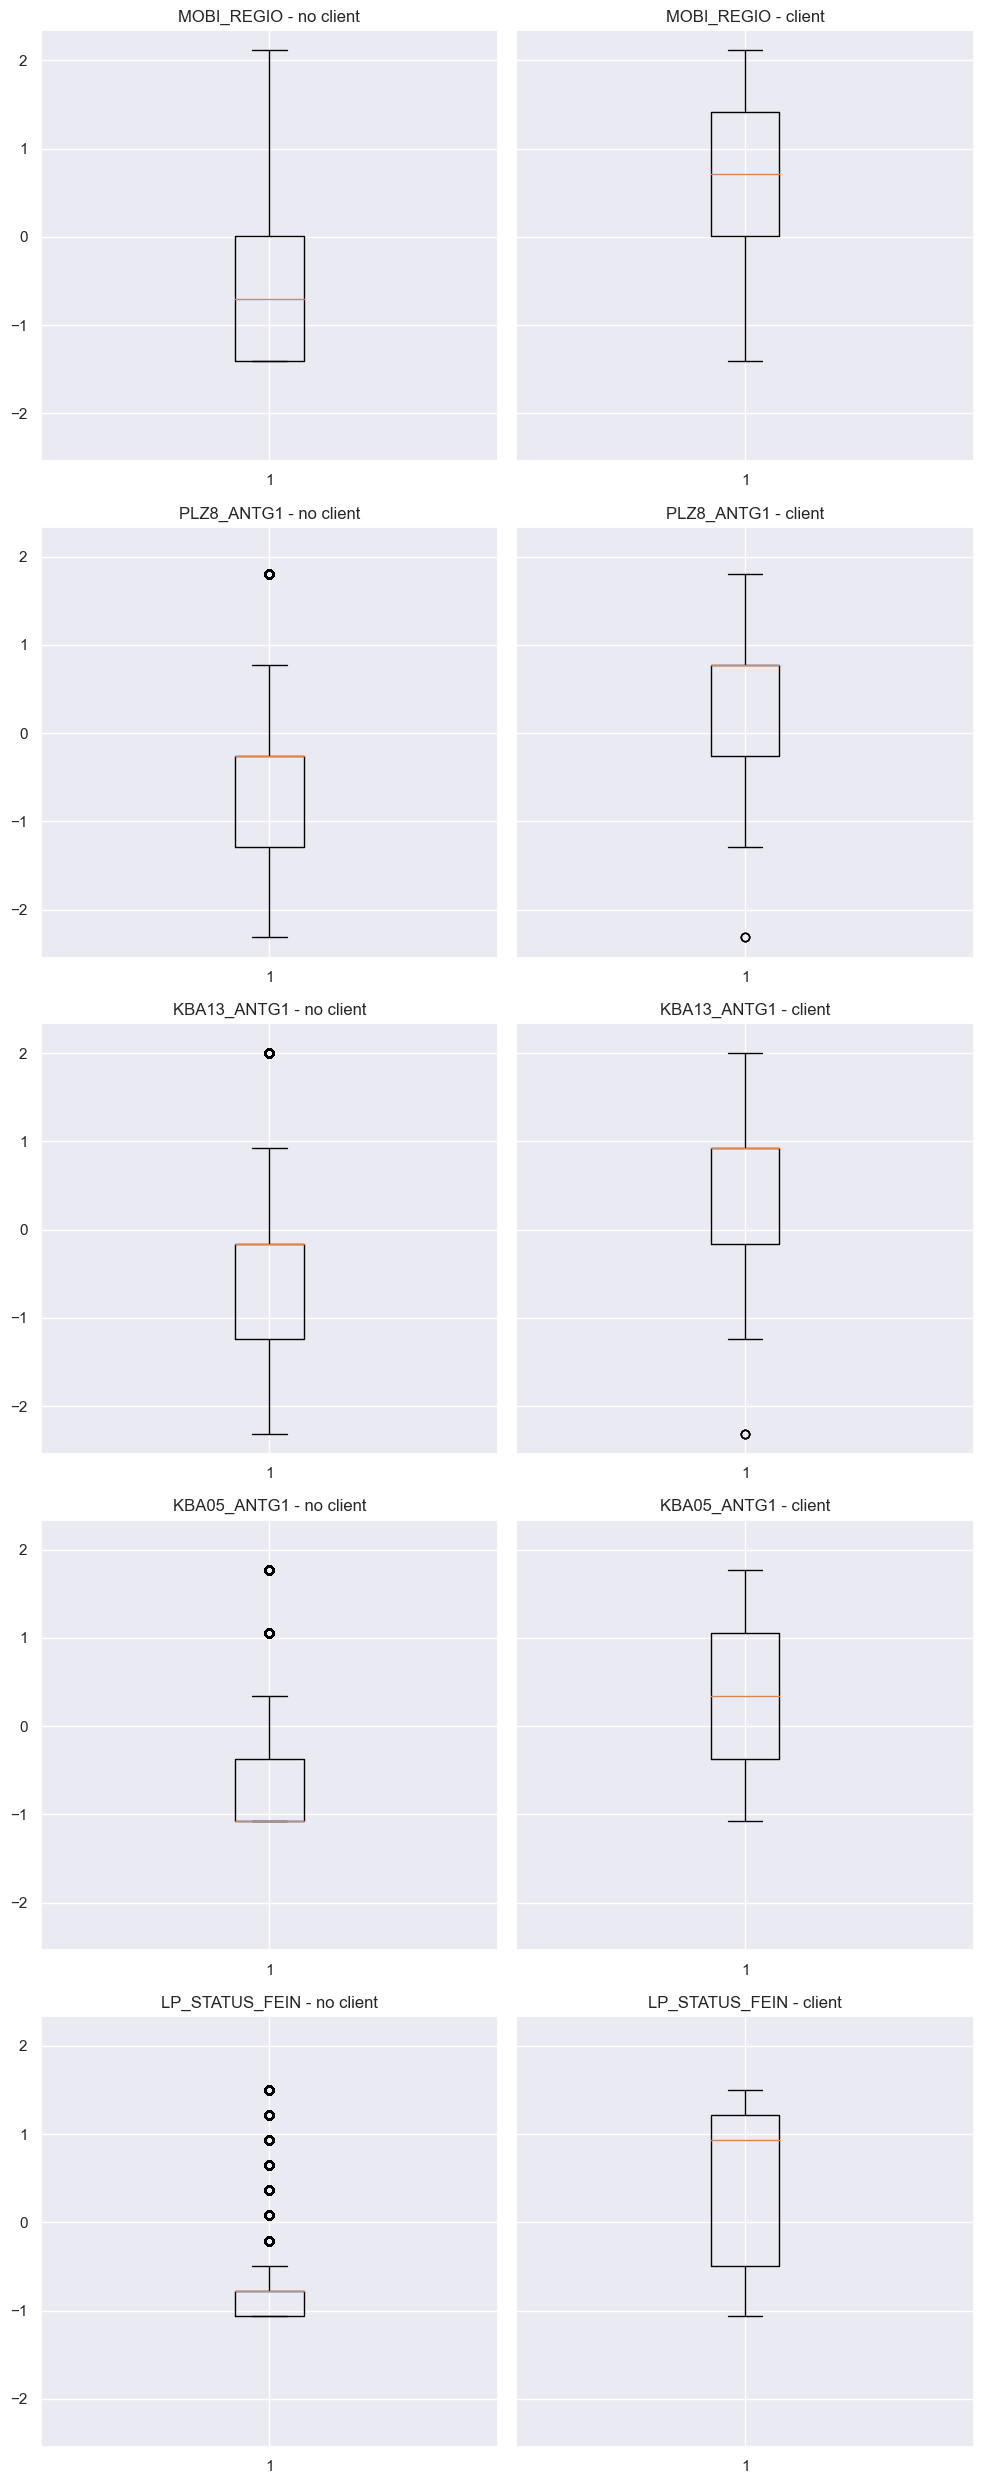

In [28]:
five_positive = ['MOBI_REGIO', 'PLZ8_ANTG1', 'KBA13_ANTG1', 'KBA05_ANTG1', 'LP_STATUS_FEIN']

fig, ax = plt.subplots(figsize=(10, 25), nrows=len(five_positive), ncols=2, tight_layout=True, sharey=True)

for i, col in enumerate(five_positive):
    ax[i, 0].set_title(col + ' - no client')
    ax[i, 0].boxplot(not_client[col])
    ax[i, 1].set_title(col + ' - client')
    ax[i, 1].boxplot(client[col])

In [28]:
all_info[all_info['Attribute'].isin(five_positive)]

,Information level,Attribute,Value,Meaning,Description,Additional notes
795,Microcell (RR4_ID),KBA05_ANTG1,[-1],unknown,number of 1-2 family houses in the cell,NaN
796,Microcell (RR4_ID),KBA05_ANTG1,[0],no 1-2 family homes,number of 1-2 family houses in the cell,NaN
797,Microcell (RR4_ID),KBA05_ANTG1,[1],lower share of 1-2 family homes,number of 1-2 family houses in the cell,NaN
798,Microcell (RR4_ID),KBA05_ANTG1,[2],average share of 1-2 family homes,number of 1-2 family houses in the cell,NaN
799,Microcell (RR4_ID),KBA05_ANTG1,[3],high share of 1-2 family homes,number of 1-2 family houses in the cell,NaN
800,Microcell (RR4_ID),KBA05_ANTG1,[4],very high share of 1-2 family homes,number of 1-2 family houses in the cell,NaN
1966,Person,LP_STATUS_FEIN,[1],typical low-income earners,social status fine,NaN
1967,Person,LP_STATUS_FEIN,[2],orientationseeking low-income earners,social status fine,NaN
1968,Person,LP_STATUS_FEIN,[3],aspiring low-income earners,social status fine,NaN
1969,Person,LP_STATUS_FEIN,[4],villagers,social status fine,NaN


We can see the same pattern for all above feattures: Most of values are positive in *clients* group while they are negative in *no client* group. Since we already applied scaling to mean = 0, this means any values above 0 is above means and under 0 is under mean.

1. The `MOBI_REGIO` column is related to mobility, high values in clients indicate low mobility.
2. The `PLZ8_ANTG1` column indicate the number of 1-2 family houses in PLZ8 (this is zipcode), high values (clients) indicate more houses.
3. The `KBA05_ANTG1` column is the same as `PLZ8_ANTG1` but by cell.
4. The `LP_STATUS_FEIN` column is related to social status, high values (clients) indicate better status.
5. The `KBA13_ANTG1` is not defined in description file so I can not assume anything.

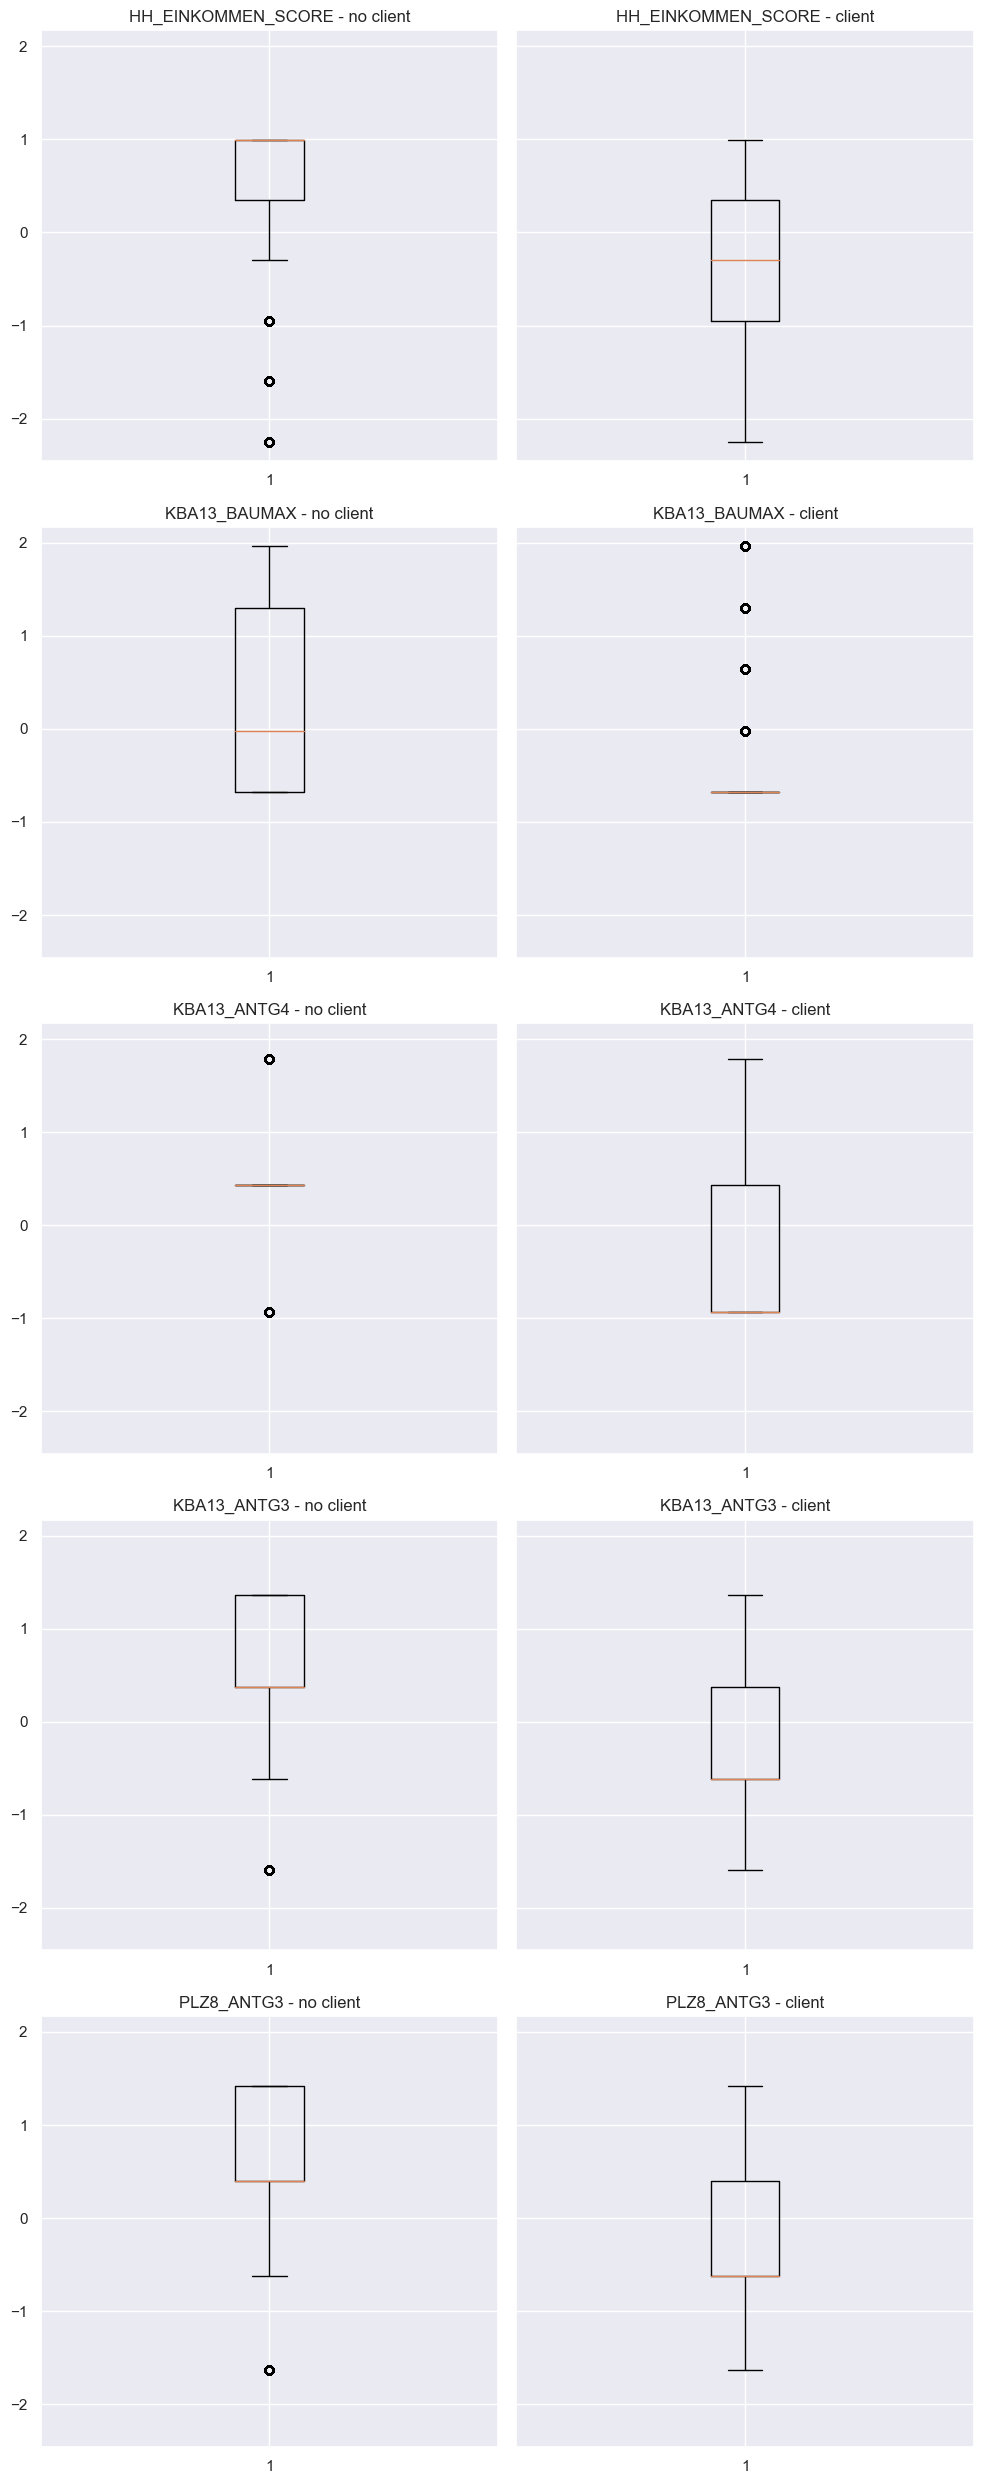

In [29]:
five_negative = ['HH_EINKOMMEN_SCORE', 'KBA13_BAUMAX', 'KBA13_ANTG4', 'KBA13_ANTG3', 'PLZ8_ANTG3']

fig, ax = plt.subplots(figsize=(10, 25), nrows=len(five_negative), ncols=2, tight_layout=True, sharey=True)

for i, col in enumerate(five_negative):
    ax[i, 0].set_title(col + ' - no client')
    ax[i, 0].boxplot(not_client[col])
    ax[i, 1].set_title(col + ' - client')
    ax[i, 1].boxplot(client[col])

In [34]:
all_info[all_info['Attribute'].isin(five_negative)]

,Information level,Attribute,Value,Meaning,Description,Additional notes
749,Household,HH_EINKOMMEN_SCORE,"[-1, 0]",unknown,estimated household net income,modelled on different AZ DIAS data
750,Household,HH_EINKOMMEN_SCORE,[1],highest income,estimated household net income,modelled on different AZ DIAS data
751,Household,HH_EINKOMMEN_SCORE,[2],very high income,estimated household net income,modelled on different AZ DIAS data
752,Household,HH_EINKOMMEN_SCORE,[3],high income,estimated household net income,modelled on different AZ DIAS data
753,Household,HH_EINKOMMEN_SCORE,[4],average income,estimated household net income,modelled on different AZ DIAS data
754,Household,HH_EINKOMMEN_SCORE,[5],lower income,estimated household net income,modelled on different AZ DIAS data
755,Household,HH_EINKOMMEN_SCORE,[6],very low income,estimated household net income,modelled on different AZ DIAS data
2028,PLZ8,PLZ8_ANTG3,[-1],unknown,number of 6-10 family houses in the PLZ8,NaN
2029,PLZ8,PLZ8_ANTG3,[0],none,number of 6-10 family houses in the PLZ8,NaN
2030,PLZ8,PLZ8_ANTG3,[1],low share,number of 6-10 family houses in the PLZ8,NaN


For this three features: `PLZ8_ANTG3`, `HH_EINKOMMEN_SCORE`, the opposity ocurs.

1. The `PLZ8_ANTG3` indicates the amount of 6-10 family houses, low values in clients means few houses. 
2. The `HH_EINKOMMEN_SCORE` indicates income, low values in clients are the highest incomes.

For features `KBA13_BAUMAX`, `KBA13_ANTG4`, `KBA13_ANTG3`, I can not find these two column in metadata files so I can't assume their meaning.

**Conclusion**

Based on my findings, the company are looking for people with low mobility, high income, high social status and a neighborhood with housers from 1-2 families.

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Load train dataset

In [3]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('train.csv', sep=';')
all_info = clean.load_metadata('all_info.csv')

C:\Users\NHAN\AppData\Local\Temp\ipykernel_4664\1181711993.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('train.csv', sep=';')


In [5]:
train_clean = clean.clean_demographics(mailout_train, all_info)

c:\Users\NHAN\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [6]:
train_clean.shape

(33268, 426)

### Train split

Split train into two parts, `X_train` and `y_train`.

In [7]:
y_train = train_clean['RESPONSE']
X_train = train_clean.drop(columns='RESPONSE')

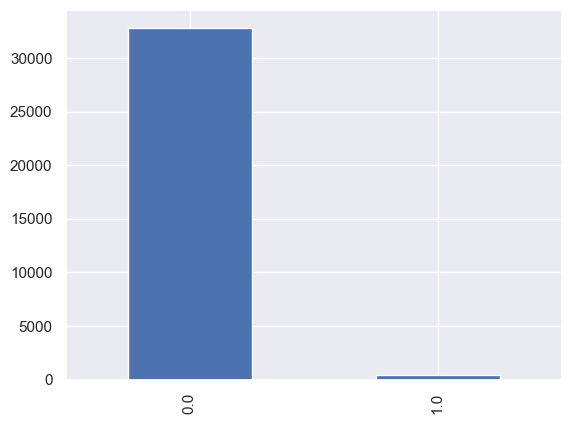

In [8]:
y_train.value_counts().plot.bar()

The data is very imbalanced so this train dataset should not be splitted into train and validation. I will keep it and train with the model.

In addition, I will not use `accuracy` as metric as the imbalance. I would use `roc_auc` to evaluate the performance of the models.

### Pre-processing and train model

#### Scale the data

In [9]:
X_cols = list(X_train.columns.values)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=X_cols)
X_train.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE

#### Try with different models

In [10]:
logreg = LogisticRegression(n_jobs=-1)
svc = SVC()
random = RandomForestClassifier(n_jobs=-1)
gbc = GradientBoostingClassifier()
mlp = MLPClassifier()

In [11]:
models = [logreg,svc,random,gbc,mlp]
for model in models:
        time_0 = time.time()
        grid = GridSearchCV(estimator=model, param_grid={}, scoring='roc_auc', cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        time_1 = time.time()
        print(model, grid.best_score_, round(time_1-time_0))
        print(grid.best_estimator_)

LogisticRegression(n_jobs=-1) 0.6661657181375542 28
LogisticRegression(n_jobs=-1)
SVC() 0.6400015464346519 503
SVC()
RandomForestClassifier(n_jobs=-1) 0.5986347437178103 7
RandomForestClassifier(n_jobs=-1)
GradientBoostingClassifier() 0.7796446715331209 109
GradientBoostingClassifier()
MLPClassifier() 0.6481007452536016 40
MLPClassifier()


From the result, `GradientBoostingClassifier` is the model with highest accuracy and the amount of time to train it is reasonable too (109 seconds)

#### Tune the hyperparameter

I try to tune the hyperparameter for the model with the values defined in param_grid variable below.

In [12]:
param_grid = {'max_depth': [3,4,5],
             'loss':['deviance', 'exponential'],
             'n_estimators': [100, 150, 200]}

best = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
best.fit(X_train, y_train)

print(best.best_score_,best.best_estimator_)

0.7803279346275351 GradientBoostingClassifier(loss='exponential', max_depth=5, n_estimators=150)


The model is improved a little bit by using following hyperparameters:
1. loss is exponential
2. max_depth is 5
2. number of estimators is 150 

In [13]:
classifier = GradientBoostingClassifier(max_depth=5, loss='exponential', n_estimators=150)
best_model = classifier.fit(X_train,y_train)

### Predict on test dataset

#### Load and pre-process the test dataset

In [14]:
mailout_test = pd.read_csv('test.csv', sep=';')

C:\Users\NHAN\AppData\Local\Temp\ipykernel_4664\895538052.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('test.csv', sep=';')


In [15]:
LNR_col = mailout_test['LNR']

In [18]:
cleaned_test = clean.clean_demographics(mailout_test, all_info, del_rows=False)
test_cols = list(cleaned_test.columns.values)

c:\Users\NHAN\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [19]:
X_test = scaler.transform(cleaned_test)
X_test = pd.DataFrame(X_test, columns=test_cols)

#### Predict on test dataset

In [37]:
proba = best_model.predict_proba(X_test)

In [39]:
proba

array([[9.81962510e-01, 1.80374902e-02],
       [9.95813055e-01, 4.18694480e-03],
       [9.99904805e-01, 9.51946789e-05],
       ...,
       [9.89867314e-01, 1.01326859e-02],
       [9.97734804e-01, 2.26519622e-03],
       [9.96284522e-01, 3.71547753e-03]])

First column of `proba` is the probability to be zero; Second column is the probability to be one.

In [22]:
predictions = pd.DataFrame(LNR_col)

In [23]:
predictions['RESPONSE'] = proba[:,1]

In [40]:
predictions.to_csv('results/prediction.csv', index=False)

In [41]:
predictions.shape

(42833, 2)

In [42]:
predictions.head()

,LNR,RESPONSE
0,1754,0.018037
1,1770,0.004187
2,1465,0.000095
3,1470,0.000105
4,1478,0.000068


## Part 4: Conclusion

I love this project as I know a lot more about Data wragling and training model. Besides, I learn a lot about analyzing a dataset to choose the best feature for training model. Though it's still so hard for a newbie like me, I already overcome and come to the final steps.

The final conclusion: the company are looking for people with low mobility, high income, high social status and a neighborhood with housers from 1-2 families. I am stil not satisfied with this conclusion but that is all that I could find. 

**What can I do to improve the model?**
1. Feature engineering for some features such as converting the year variable to buckets
2. Fill NaNs with mean or some other technique
3. Test more models or a bigger parameter space